# Prediction of League of Legends matches at 15 minutes

![alt text](https://cdn1.epicgames.com/offer/24b9b5e323bc40eea252a10cdd3b2f10/EGS_LeagueofLegends_RiotGames_S1_2560x1440-80471666c140f790f28dff68d72c384b)

The goal of this notebook is to train several different machine learning models to try and predict the outcome of a `League of Legends` match, with only information about the match at the 15 minutes mark.

To do that, we will be using 4 different types of models:

- Decision Tree Classifiers
- SVM
- K-Nearest Neighbours
- Neural Networks

Furthermore, regarding `Decision Tree Classifiers`, we will be using different methods to improve its performance, such as `Feature Selection` and using `Ensemble Methods` like the `Random Forest Classifier` and `Gradient Boosting Classifier`.

## Imports

We need a few libraries to help the development of this project.

Most models we will be using are part of the `Sci-Kit Learn` library except for the `Neural Network`, for which we will be using `TensorFlow`.

In [ ]:
import numpy as np
import pandas as pd
import math
import time
import requests
import statistics as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance

%pip install tensorflow
import tensorflow as tf


## Building the DataFrame

Now we create a dataframe with the information in the `match_data_v5.csv` and set the name of each column.

In [5]:
data = pd.read_csv('match_data_v5.csv')
data.columns = ["matchID","blueTeamControlWardsPlaced","blueTeamWardsPlaced","blueTeamTotalKills","blueTeamDragonKills","blueTeamHeraldKills","blueTeamTowersDestroyed","blueTeamInhibitorsDestroyed","blueTeamTurretPlatesDestroyed","blueTeamFirstBlood","blueTeamMinionsKilled","blueTeamJungleMinions","blueTeamTotalGold","blueTeamXp","blueTeamTotalDamageToChamps",
                            "redTeamControlWardsPlaced","redTeamWardsPlaced","redTeamTotalKills","redTeamDragonKills","redTeamHeraldKills","redTeamTowersDestroyed","redTeamInhibitorsDestroyed","redTeamTurretPlatesDestroyed","redTeamMinionsKilled","redTeamJungleMinions","redTeamTotalGold","redTeamXp","redTeamTotalDamageToChamps","blueWin","empty"]
data.head()

,matchID,blueTeamControlWardsPlaced,blueTeamWardsPlaced,blueTeamTotalKills,blueTeamDragonKills,blueTeamHeraldKills,blueTeamTowersDestroyed,blueTeamInhibitorsDestroyed,blueTeamTurretPlatesDestroyed,blueTeamFirstBlood,...,redTeamTowersDestroyed,redTeamInhibitorsDestroyed,redTeamTurretPlatesDestroyed,redTeamMinionsKilled,redTeamJungleMinions,redTeamTotalGold,redTeamXp,redTeamTotalDamageToChamps,blueWin,empty
0,EUW1_6882489515',2,23,4,2,0,0,0,7,0,...,2,0,1,400,94,29637,32613,27239,1,0
1,EUW1_6882416210',2,46,12,1,0,1,0,10,0,...,1,0,4,373,76,28970,30320,36585,0,0
2,EUW1_6881092720',2,19,13,0,0,0,0,11,0,...,2,0,3,340,84,30510,29464,42984,0,0
3,EUW1_6879405717',3,28,8,0,1,1,0,9,1,...,0,0,5,378,87,25157,31069,28229,0,0
4,EUW1_6879389461',3,30,11,1,1,1,0,7,0,...,1,0,5,382,96,26052,29475,19245,1,0


Now we drop the `empty` columns, since they are not relevant to the analysis.

In [6]:
data = data.drop(columns=["empty"])
data.head()

,matchID,blueTeamControlWardsPlaced,blueTeamWardsPlaced,blueTeamTotalKills,blueTeamDragonKills,blueTeamHeraldKills,blueTeamTowersDestroyed,blueTeamInhibitorsDestroyed,blueTeamTurretPlatesDestroyed,blueTeamFirstBlood,...,redTeamHeraldKills,redTeamTowersDestroyed,redTeamInhibitorsDestroyed,redTeamTurretPlatesDestroyed,redTeamMinionsKilled,redTeamJungleMinions,redTeamTotalGold,redTeamXp,redTeamTotalDamageToChamps,blueWin
0,EUW1_6882489515',2,23,4,2,0,0,0,7,0,...,0,2,0,1,400,94,29637,32613,27239,1
1,EUW1_6882416210',2,46,12,1,0,1,0,10,0,...,0,1,0,4,373,76,28970,30320,36585,0
2,EUW1_6881092720',2,19,13,0,0,0,0,11,0,...,0,2,0,3,340,84,30510,29464,42984,0
3,EUW1_6879405717',3,28,8,0,1,1,0,9,1,...,0,0,0,5,378,87,25157,31069,28229,0
4,EUW1_6879389461',3,30,11,1,1,1,0,7,0,...,0,1,0,5,382,96,26052,29475,19245,1


Let's check for duplicated games with the same matchID and delete them

In [7]:
duplicate_rows = data[data.duplicated(['matchID'])]
print("Number of duplicate rows: ", duplicate_rows.shape[0])
data = data.drop_duplicates(subset='matchID', keep='first')

Number of duplicate rows:  7


Now since `matchID` was only relevant to check for duplicated games, we can drop the column

In [8]:
data = data.drop(columns=["matchID"])
data.head()

,blueTeamControlWardsPlaced,blueTeamWardsPlaced,blueTeamTotalKills,blueTeamDragonKills,blueTeamHeraldKills,blueTeamTowersDestroyed,blueTeamInhibitorsDestroyed,blueTeamTurretPlatesDestroyed,blueTeamFirstBlood,blueTeamMinionsKilled,...,redTeamHeraldKills,redTeamTowersDestroyed,redTeamInhibitorsDestroyed,redTeamTurretPlatesDestroyed,redTeamMinionsKilled,redTeamJungleMinions,redTeamTotalGold,redTeamXp,redTeamTotalDamageToChamps,blueWin
0,2,23,4,2,0,0,0,7,0,388,...,0,2,0,1,400,94,29637,32613,27239,1
1,2,46,12,1,0,1,0,10,0,348,...,0,1,0,4,373,76,28970,30320,36585,0
2,2,19,13,0,0,0,0,11,0,331,...,0,2,0,3,340,84,30510,29464,42984,0
3,3,28,8,0,1,1,0,9,1,355,...,0,0,0,5,378,87,25157,31069,28229,0
4,3,30,11,1,1,1,0,7,0,370,...,0,1,0,5,382,96,26052,29475,19245,1


In [9]:
data.describe()

,blueTeamControlWardsPlaced,blueTeamWardsPlaced,blueTeamTotalKills,blueTeamDragonKills,blueTeamHeraldKills,blueTeamTowersDestroyed,blueTeamInhibitorsDestroyed,blueTeamTurretPlatesDestroyed,blueTeamFirstBlood,blueTeamMinionsKilled,...,redTeamHeraldKills,redTeamTowersDestroyed,redTeamInhibitorsDestroyed,redTeamTurretPlatesDestroyed,redTeamMinionsKilled,redTeamJungleMinions,redTeamTotalGold,redTeamXp,redTeamTotalDamageToChamps,blueWin
count,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,...,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.00000,24218.000000,24218.000000,24218.000000
mean,3.610414,41.364316,12.790941,0.737881,0.123627,0.654802,0.002023,8.915270,0.503923,349.241886,...,0.103146,0.955075,0.001528,3.883640,350.290363,88.547444,27787.86605,29618.844578,32154.973160,0.494550
std,2.018264,43.477286,4.909179,0.722118,0.329288,0.885765,0.054109,3.083979,0.499995,31.343136,...,0.304156,0.981834,0.044028,2.590925,31.595285,14.121506,2693.45931,1896.260771,6040.329498,0.499981
min,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,194.000000,...,0.000000,0.000000,0.000000,0.000000,188.000000,0.000000,18247.00000,17602.000000,10383.000000,0.000000
25%,2.000000,25.000000,9.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,329.000000,...,0.000000,0.000000,0.000000,2.000000,330.000000,79.000000,25910.00000,28387.000000,28024.000000,0.000000
50%,3.000000,29.000000,12.000000,1.000000,0.000000,0.000000,0.000000,9.000000,1.000000,350.000000,...,0.000000,1.000000,0.000000,4.000000,351.000000,88.000000,27629.00000,29631.000000,31936.000000,0.000000
75%,5.000000,35.000000,16.000000,1.000000,0.000000,1.000000,0.000000,11.000000,1.000000,371.000000,...,0.000000,1.000000,0.000000,5.000000,372.000000,98.000000,29512.75000,30865.750000,36028.000000,1.000000
max,37.000000,603.000000,38.000000,2.000000,2.000000,10.000000,2.000000,22.000000,1.000000,465.000000,...,1.000000,10.000000,2.000000,15.000000,464.000000,156.000000,41227.00000,36797.000000,62452.000000,1.000000


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24218 entries, 0 to 24224
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   blueTeamControlWardsPlaced     24218 non-null  int64
 1   blueTeamWardsPlaced            24218 non-null  int64
 2   blueTeamTotalKills             24218 non-null  int64
 3   blueTeamDragonKills            24218 non-null  int64
 4   blueTeamHeraldKills            24218 non-null  int64
 5   blueTeamTowersDestroyed        24218 non-null  int64
 6   blueTeamInhibitorsDestroyed    24218 non-null  int64
 7   blueTeamTurretPlatesDestroyed  24218 non-null  int64
 8   blueTeamFirstBlood             24218 non-null  int64
 9   blueTeamMinionsKilled          24218 non-null  int64
 10  blueTeamJungleMinions          24218 non-null  int64
 11  blueTeamTotalGold              24218 non-null  int64
 12  blueTeamXp                     24218 non-null  int64
 13  blueTeamTotalDamageTo

### Cleaning up the data

We need to cleanup the data so we don't train the models with faulty data, which leads to worse performance.

Let's take a look at the data correlation to ensure everything is okay.

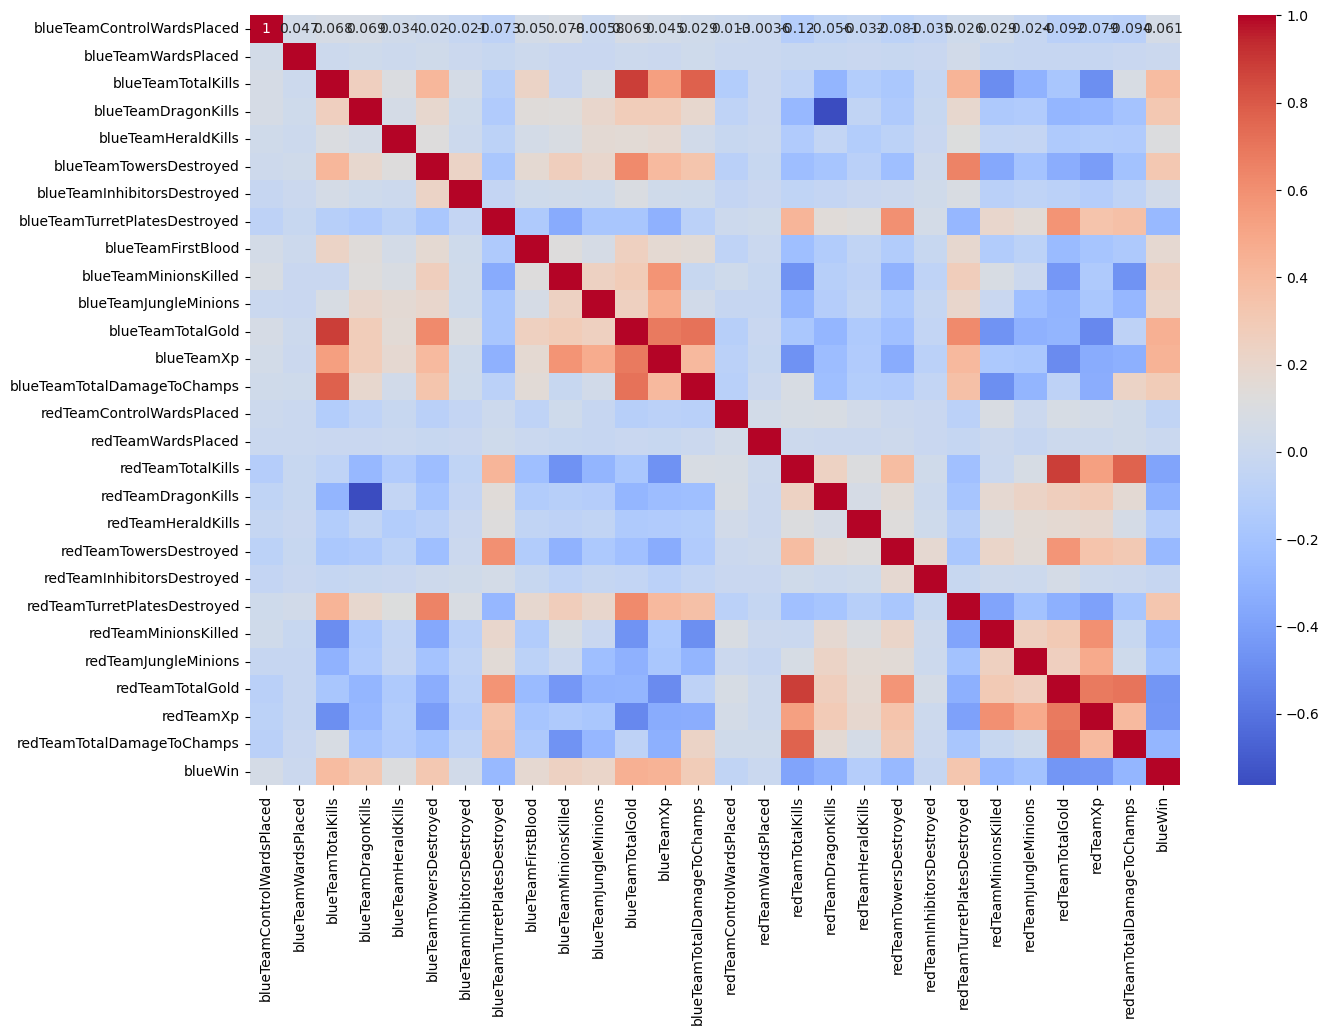

In [11]:
correlation = data.corr()
plt.figure(figsize=(15,10))
sb.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

Looking at this heatmap, we notice that there's a weird correlation between `Turrets Destroyed` and their respective team `Turret Plates Destroyed`. If a tower is destroyed within 14 minutes of the start of the game, said team also destroys 5 plates. This means that the more turrets they destroy within 15 minutes, then the more turret plates they should've also destroyed. The heatmap seems to have both values swapped, as the correlation value between opposite team tower destroyed and plates destroyed is very high while for the same team is very low. Our thought process is also reinforced by looking at the strangely high correlation between the turret plates destroyed and the enemy team's gold, because, since destroying turret plates give your team gold, then the high correlation should be between the same team's gold, not the other way around.

In [12]:
data.rename(columns={'blueTeamTurretPlatesDestroyed': 'redTeamTurretPlatesDestroyed', 'redTeamTurretPlatesDestroyed': 'blueTeamTurretPlatesDestroyed'}, inplace=True)

Now let's take a look at all the maximum values of each column, this way we ensure that attributes with an impossible value don't exist.

In [13]:
max_values = data.max()
print(max_values)

blueTeamControlWardsPlaced          37
blueTeamWardsPlaced                603
blueTeamTotalKills                  38
blueTeamDragonKills                  2
blueTeamHeraldKills                  2
blueTeamTowersDestroyed             10
blueTeamInhibitorsDestroyed          2
redTeamTurretPlatesDestroyed        22
blueTeamFirstBlood                   1
blueTeamMinionsKilled              465
blueTeamJungleMinions              156
blueTeamTotalGold                40968
blueTeamXp                       36801
blueTeamTotalDamageToChamps      62857
redTeamControlWardsPlaced           15
redTeamWardsPlaced                 576
redTeamTotalKills                   37
redTeamDragonKills                   2
redTeamHeraldKills                   1
redTeamTowersDestroyed              10
redTeamInhibitorsDestroyed           2
blueTeamTurretPlatesDestroyed       15
redTeamMinionsKilled               464
redTeamJungleMinions               156
redTeamTotalGold                 41227
redTeamXp                

By looking closely at this, we notice strange values for `redTeamTurretPlatesDestroyed`, because their value is greater than 15, which is the maximum amount of turret plates per game, so we must remove these values.

In [14]:
print("Size before removing wrong values: ", data.shape)

remove_extra_plates_red = data[(data['redTeamTurretPlatesDestroyed'] > 15)]
data.drop(remove_extra_plates_red.index, inplace=True)
remove_extra_plates_blue = data[(data['blueTeamTurretPlatesDestroyed'] > 15)]
data.drop(remove_extra_plates_blue.index, inplace=True)

print("Size after removing wrong values: ", data.shape)

Size before removing wrong values:  (24218, 28)
Size after removing wrong values:  (23678, 28)


Let's also make sure our dataset is balanced!

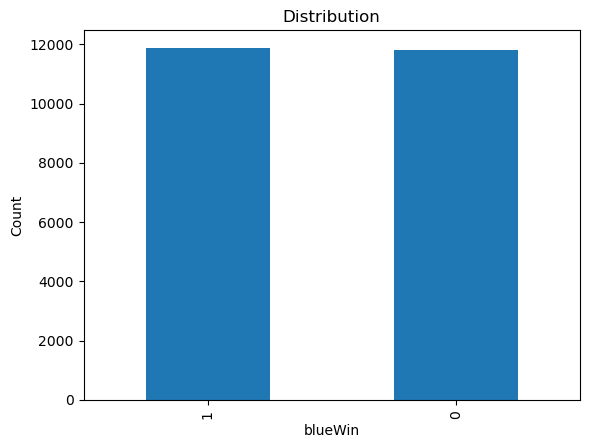

In [15]:
label_distribution = data['blueWin'].value_counts()

label_distribution.plot(kind='bar')
plt.title('Distribution')
plt.xlabel('blueWin')
plt.ylabel('Count')
plt.show()

## Analyzing the data

Let's plot some graphs with a few attributes of a match to see what we can infer about them.

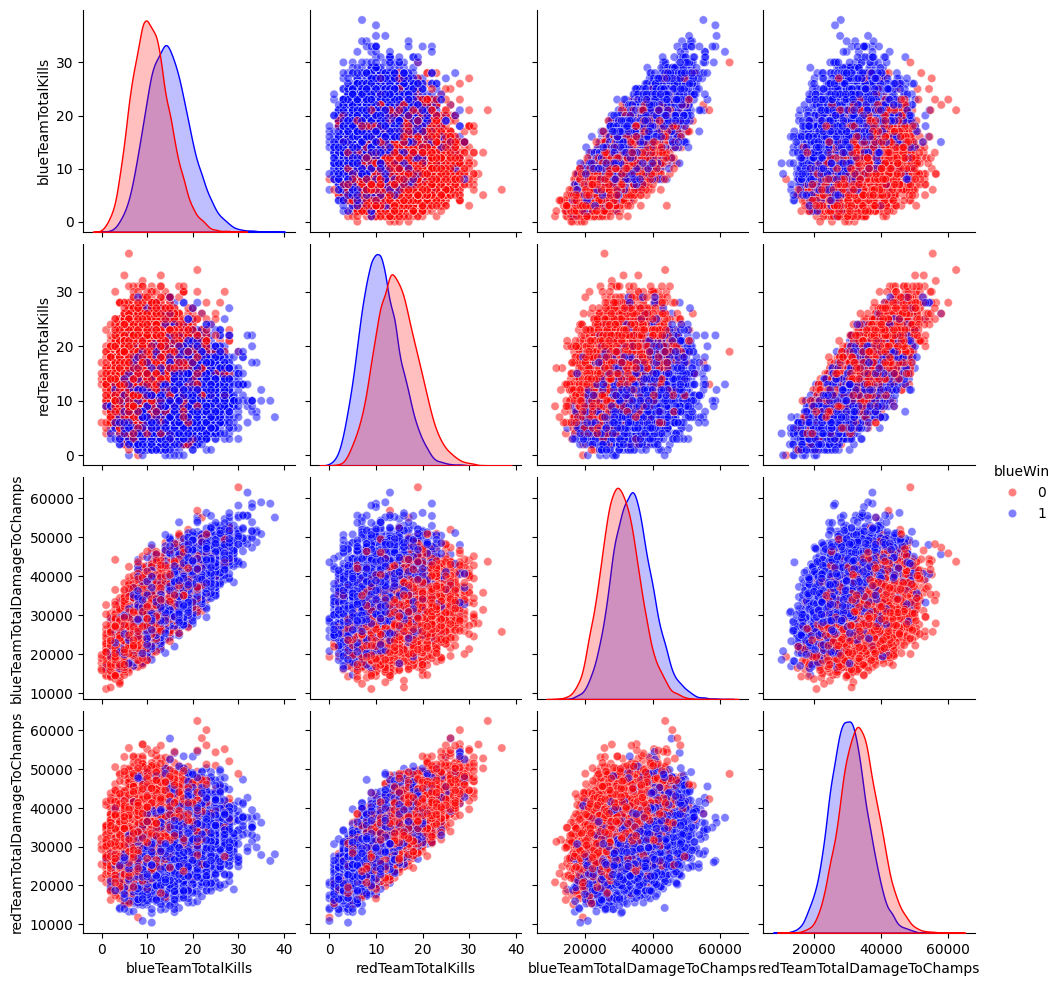

In [11]:
sample_size = data.__len__()
attributes = ['blueTeamTotalKills', 'redTeamTotalKills', 'blueTeamTotalDamageToChamps', 'redTeamTotalDamageToChamps', 'blueWin']

sample = data.sample(sample_size)[attributes]

palette = {0: "red", 1: "blue"}
sb.pairplot(sample, hue='blueWin', palette=palette, plot_kws={'alpha':0.5})

We are trying to find a correlation between game states and whether or not they lead to a victory.
In this case, `Red` means the `Blue` team lost, whereas `Blue` means the `Blue` team won.

From these graphs, we can see some contributing factors to a win:

- Total Kills:
    If we compare `redTeamTotalKills` and `blueTeamTotalKills`, we can see that games are mostly won by the teams with more kills.
- Total Damage to Champions:
    Much like total kills, it appears as if the team with most total damage to champions tends to win the game.
    The graph comparing each team's total damage to champions is quite similar to the graph comparing total kills. This is because these two variables are very intertwined, since, generally, dealing damage to enemy champions may result in their death.

Now, we will create some violin plots to further analyze the data.

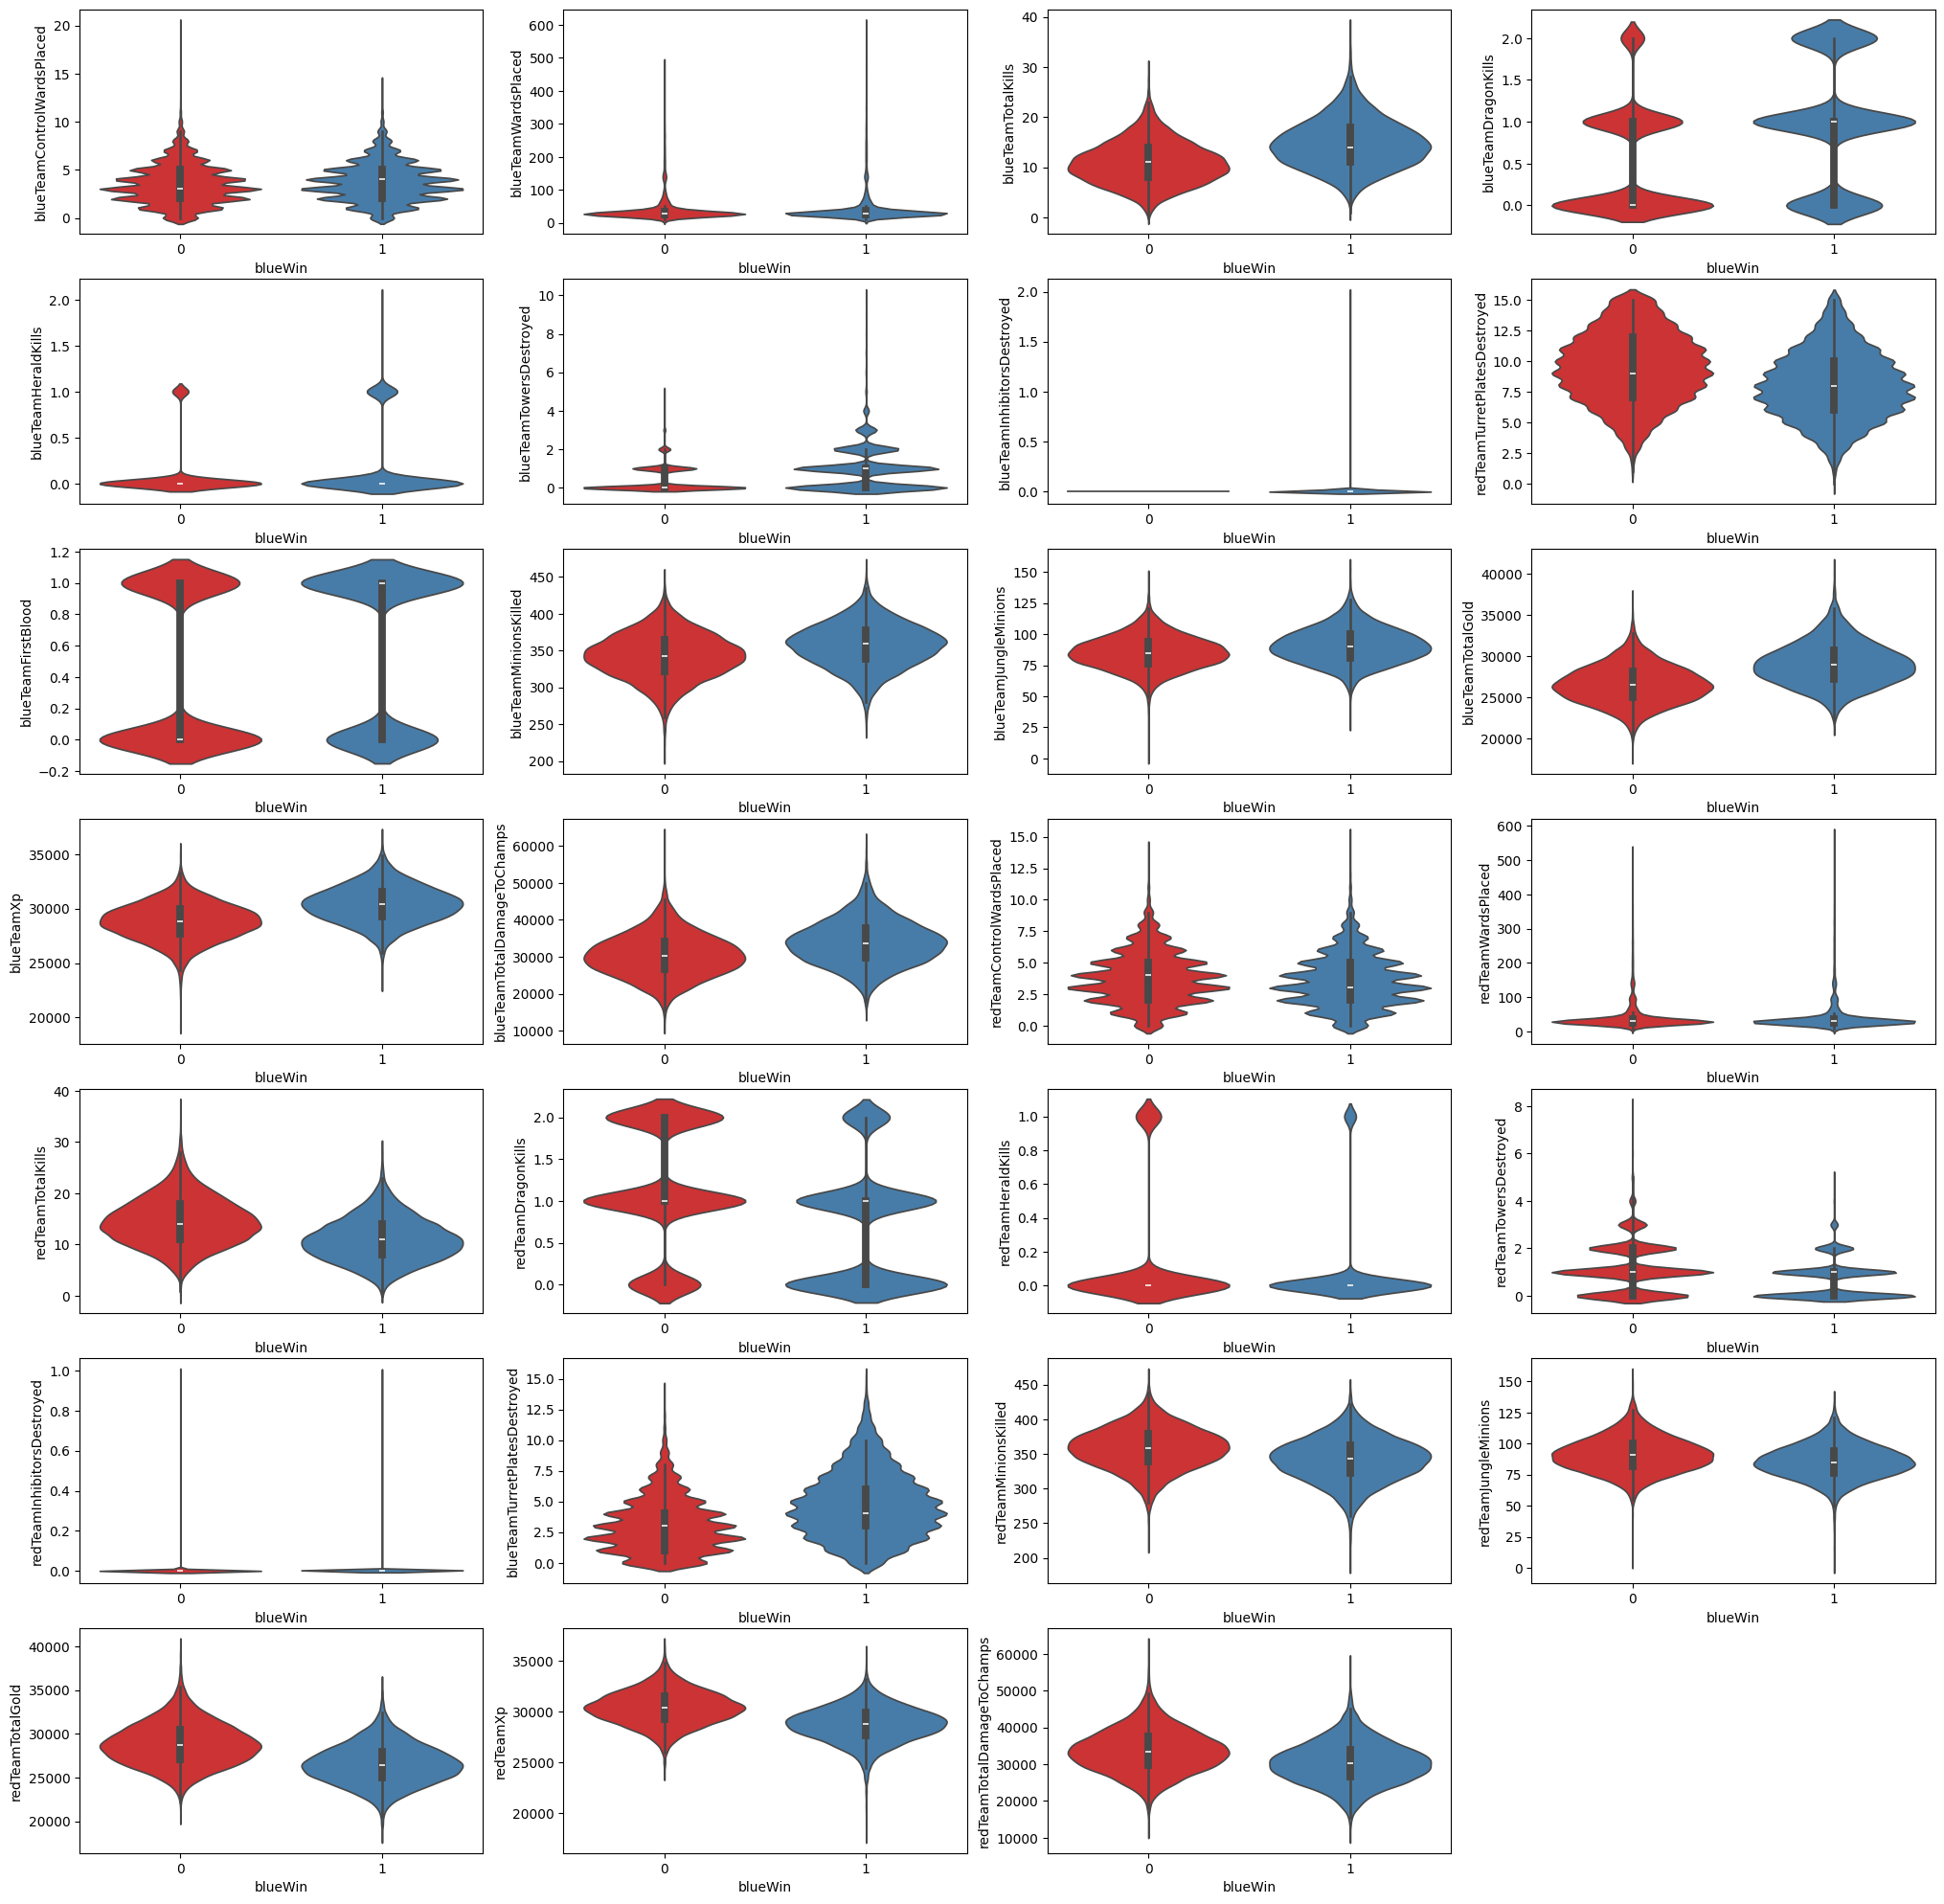

In [17]:
plt.figure(figsize=(25, 25))

num_columns = 4
num_rows = math.ceil(len(data.columns) / num_columns)

for column_index, column in enumerate(data.columns):
    if column == 'blueWin':
        continue
    plt.subplot(num_rows, num_columns, column_index + 1)
    sb.violinplot(x='blueWin', y=column, data=data, palette='Set1', hue='blueWin', legend=False)

## Classification

Now, we will start the classification process.

### Decision Tree Classifier

We are going to create a simple `Decision Tree Classifier`, no additional performance boosters.

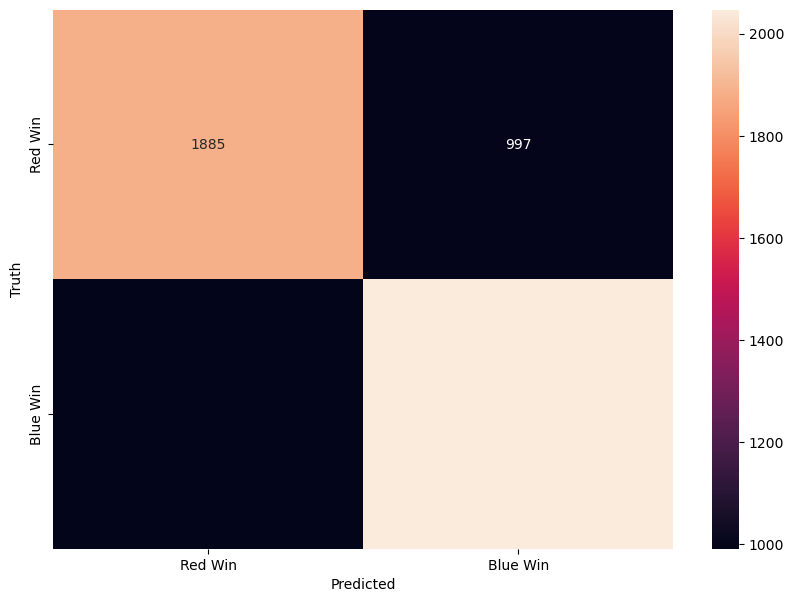

Decision Tree Classifier Accuracy: 66.4%
Classification Report for Decision Tree Classifier:
              precision    recall  f1-score      support
0              0.655424  0.654060  0.654741  2882.000000
1              0.672470  0.673799  0.673134  3038.000000
accuracy       0.664189  0.664189  0.664189     0.664189
macro avg      0.663947  0.663929  0.663938  5920.000000
weighted avg   0.664172  0.664189  0.664180  5920.000000


In [51]:
new_data = data.drop(columns=['blueWin'])
inputs = new_data.values
labels = data['blueWin'].values

(training_inputs, testing_inputs, training_labels, testing_labels) = train_test_split(inputs, labels, test_size=0.25, random_state=42) # 42 is the answer to everything

decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(training_inputs, training_labels)
predictions = decision_tree_classifier.predict(testing_inputs)

cm = confusion_matrix(testing_labels, predictions)

plt.figure(figsize=(10, 7))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=['Red Win', 'Blue Win'], yticklabels=['Red Win', 'Blue Win'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

accuracy = round(accuracy_score(testing_labels, predictions), 3) * 100
print(f'Decision Tree Classifier Accuracy: {accuracy}%')

cr = classification_report(testing_labels, predictions, output_dict=True)
df_report = pd.DataFrame(cr).transpose()
print("Classification Report for Decision Tree Classifier:")
print(df_report)

In [52]:
dt_scores = cross_val_score(decision_tree_classifier, inputs, labels, cv=10)

print("Cross-validation scores: ", dt_scores)
print("Mean cross-validation score: ", dt_scores.mean())

Cross-validation scores:  [0.66047297 0.6714527  0.66131757 0.67060811 0.66258446 0.66469595
 0.65793919 0.66554054 0.67342628 0.66286439]
Mean cross-validation score:  0.6650902149773348


As we can see, we got an average score of about 66-67%. This isn't great. To improve it, we will select the most prominent features, and also use ensemble methods.


#### Ensemble Methods

Instead of using a single decision tree, we can use an ensemble of decision trees, such as a `Random Forest` or` Gradient Boosting` classifiers. These methods often perform better than a single decision tree.

##### Random Forest Classifier

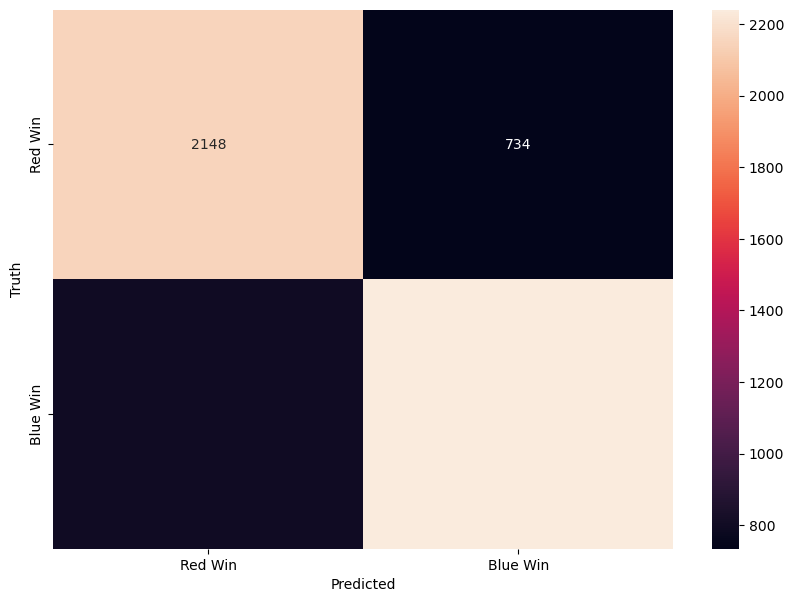

Random Forest Classifier Accuracy: 74.1%
Classification Report for Random Forest Classifier:
              precision    recall  f1-score      support
0              0.729124  0.745316  0.737131  2882.000000
1              0.753194  0.737327  0.745176  3038.000000
accuracy       0.741216  0.741216  0.741216     0.741216
macro avg      0.741159  0.741321  0.741154  5920.000000
weighted avg   0.741476  0.741216  0.741260  5920.000000


In [53]:
random_forest_classifier = RandomForestClassifier(n_estimators=100)
random_forest_classifier.fit(training_inputs, training_labels)
predictions = random_forest_classifier.predict(testing_inputs)

cm = confusion_matrix(testing_labels, predictions)

plt.figure(figsize=(10, 7))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=['Red Win', 'Blue Win'], yticklabels=['Red Win', 'Blue Win'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

accuracy = round(accuracy_score(testing_labels, predictions), 3) * 100
print(f'Random Forest Classifier Accuracy: {accuracy}%')

cr = classification_report(testing_labels, predictions, output_dict=True)
df_report = pd.DataFrame(cr).transpose()
print("Classification Report for Random Forest Classifier:")
print(df_report)

In [54]:
rfc_scores = cross_val_score(random_forest_classifier, inputs, labels, cv=10)

print("Cross-validation scores: ", rfc_scores)
print("Mean cross-validation score: ", rfc_scores.mean())

Cross-validation scores:  [0.76266892 0.7652027  0.75717905 0.76097973 0.75168919 0.75337838
 0.73986486 0.73859797 0.74524715 0.74651458]
Mean cross-validation score:  0.7521322534511697


As we can see, with a random forest classifier with 100 estimators, we bumped the score to around 75%.

##### Gradient Boosting Classifier

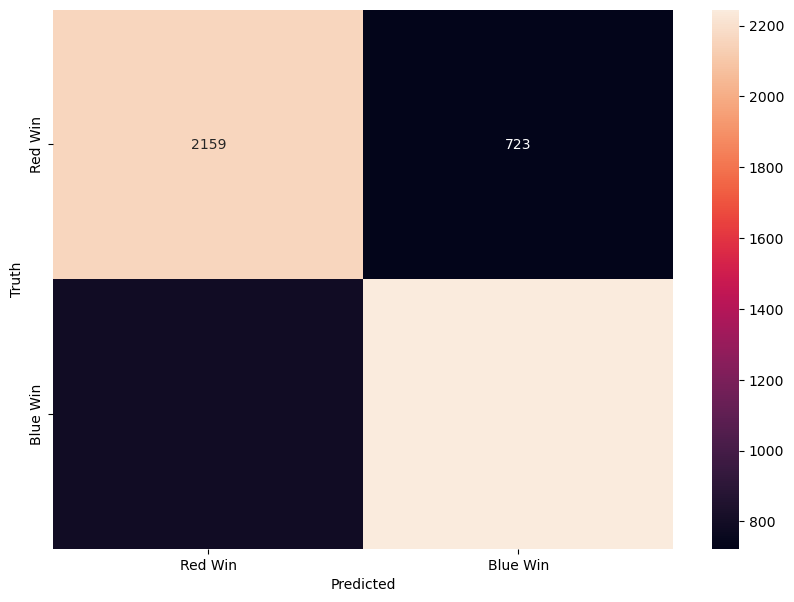

Gradient Boosting Classifier Accuracy: 74.4%
Classification Report for Gradient Boosting Classifier:
              precision    recall  f1-score      support
0              0.731369  0.749133  0.740144  2882.000000
1              0.756402  0.738973  0.747586  3038.000000
accuracy       0.743919  0.743919  0.743919     0.743919
macro avg      0.743885  0.744053  0.743865  5920.000000
weighted avg   0.744215  0.743919  0.743963  5920.000000


In [55]:
gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=4, random_state=42)
gradient_boosting_classifier.fit(training_inputs, training_labels)
predictions = gradient_boosting_classifier.predict(testing_inputs)

cm = confusion_matrix(testing_labels, predictions)

plt.figure(figsize=(10, 7))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=['Red Win', 'Blue Win'], yticklabels=['Red Win', 'Blue Win'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

accuracy = round(accuracy_score(testing_labels, predictions), 3) * 100
print(f'Gradient Boosting Classifier Accuracy: {accuracy}%')

cr = classification_report(testing_labels, predictions, output_dict=True)
df_report = pd.DataFrame(cr).transpose()
print("Classification Report for Gradient Boosting Classifier:")
print(df_report)

In [56]:
gbc_scores = cross_val_score(gradient_boosting_classifier, inputs, labels, cv=10)

print("Cross-validation scores: ", gbc_scores)
print("Mean cross-validation score: ", gbc_scores.mean())

Cross-validation scores:  [0.76773649 0.76097973 0.77364865 0.76097973 0.75337838 0.75380068
 0.73986486 0.73902027 0.7460921  0.7460921 ]
Mean cross-validation score:  0.7541592983192318


Let's compare the `Random Forest Classifier` and the `Gradient Boosting Classifier` to see which one fares better in this scenario.

In [14]:
def compare_models(model1, model2, inputs1, inputs2, labels, repetitions=10):
    model1_accuracies = []
    model2_accuracies = []

    for _ in range(repetitions):
        # Create the training and test sets for each model
        (training_inputs1,
         testing_inputs1,
         training_labels1,
         testing_labels1) = train_test_split(inputs1, labels, test_size=0.25)

        (training_inputs2,
         testing_inputs2,
         training_labels2,
         testing_labels2) = train_test_split(inputs2, labels, test_size=0.25)

        # Train the models on the training sets
        model1.fit(training_inputs1, training_labels1)
        model2.fit(training_inputs2, training_labels2)

        # Get the score of each model
        model1_accuracy = model1.score(testing_inputs1, testing_labels1)
        model2_accuracy = model2.score(testing_inputs2, testing_labels2)

        model1_accuracies.append(model1_accuracy)
        model2_accuracies.append(model2_accuracy)

    plt.hist(model1_accuracies)
    plt.hist(model2_accuracies)

    mean_difference = round((stats.mean(model2_accuracies) - stats.mean(model1_accuracies)), 4) * 100
    return mean_difference

Average difference of scores between Gradient Boosting and Random Forest: 0.24%


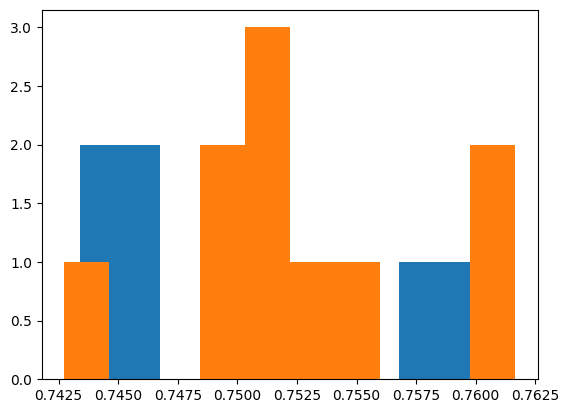

In [19]:
mean_difference = compare_models(model1=random_forest_classifier, model2=gradient_boosting_classifier, inputs1=inputs, inputs2=inputs, labels=labels, repetitions=20)
print(f'Average difference of scores between Gradient Boosting and Random Forest: {mean_difference}%')

As we can see, the `Gradient Boosting Classifier` performs very slightly better than the `Random Forest Classifier`. 

#### Feature Selection

Not all features are equally informative. We can use feature importance methods to select the most informative features to train our model.

In [57]:
# Get the feature importances
importances = gradient_boosting_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(training_inputs.shape[1]):
    print(f"{new_data.columns[indices[f]]}: {importances[indices[f]]}")

blueTeamTotalGold: 0.4355880736227441
redTeamTotalGold: 0.2992671947913562
redTeamXp: 0.11908033205357663
blueTeamXp: 0.08548688800786701
blueTeamDragonKills: 0.039247247177629604
redTeamDragonKills: 0.01159192709581799
redTeamTotalKills: 0.006414030020711318
blueTeamTotalKills: 0.0027568129632707097
blueTeamMinionsKilled: 0.00016468272814158246
redTeamWardsPlaced: 0.00015972769296264855
redTeamTotalDamageToChamps: 0.00012207297343375773
redTeamMinionsKilled: 5.6105632370379225e-05
redTeamJungleMinions: 3.611141491347435e-05
redTeamTurretPlatesDestroyed: 2.87938252046304e-05
blueTeamHeraldKills: 0.0
blueTeamTowersDestroyed: 0.0
blueTeamWardsPlaced: 0.0
blueTeamInhibitorsDestroyed: 0.0
blueTeamTotalDamageToChamps: 0.0
blueTeamFirstBlood: 0.0
blueTeamJungleMinions: 0.0
redTeamControlWardsPlaced: 0.0
redTeamHeraldKills: 0.0
redTeamTowersDestroyed: 0.0
redTeamInhibitorsDestroyed: 0.0
blueTeamTurretPlatesDestroyed: 0.0
blueTeamControlWardsPlaced: 0.0


Let's stop and analyze this for a bit, in the context of the actual game.

Looking at the top of the feature importances list, we can see `blueTeamTotalGold` and `redTeamTotalGold`. This makes sense, because, in `League of Legends`, you kill minions, enemy champions, neutral objetives and so on, so you can earn more gold, which in turn gives you the ability to buy more items, which make you stronger. The stronger you are compared to your opponent, the better odds you have of winning the game.

Alternatively, let's look at the bottom of the list. We'll ignore `Inhibitors Destroyed` for now.
Both `First Blood` and `Herald Kills` seem not too indicative of whether or not a team wins the game.
Let's think why.

`First Blood` corresponds to the first kill in the game. This tends to happen very early on, especially since our dataset contains games from mid `emerald` to high `diamond`, ranks very high up in the ranked ladder, also known to have very aggressive and chaotic games. `First Blood` is the first kill in a game. Compared to other kills, it gives a bonus 100 gold on top of the 300 gold received for killing an enemy champion. Seeing as a game spans roughly 25-40 minutes, where each player will end up having around 15000 gold (depending on the position, supports don't usually have that much gold), it makes sense that 100 gold at the beggining of the game does not impact the outcome very significantly.

`Heralds`, on the other hand, after being placed on the map, can be very helpful to destroy towers, which in turn gives the team more gold and puts more pressure on the map for the enemy team. So why is it so low? Very much like `First Blood`, the `Herald` spawns on the map very early on in the game. 
Additionally, this variable can be misleading. `Herald Kills` represents the `Herald` **Kills**, not what you actually do **with** the `Herald`. 
There is much to consider here due to several factors:

- **Killing** the `Herald` itself does not give the team much of an advantage, it's what you do **with** it
- If you do not place the `Herald` on the map 4 minutes after killing it, that ability expires and you cannot summon it anymore
- Some `Herald` summons can be very bad, and thus not really help the team that summoned it
- The `Herald` disappears from the map at 19:55 minutes into the game, if in combat. If you kill it at exactly 19:55 minutes, you have until 23:55 minutes to spawn it. Our dataset only contains information on the first 15 minutes of the game. 

With this in mind, it would make sense that these 2 factors: `First Blood` and `Herald Kills` don't tells us a lot about who is going to win the game.

In [58]:
top_features = [new_data.columns[indices[i]] for i in indices if importances[indices[i]] != 0.0]
data_top_features = data[top_features]

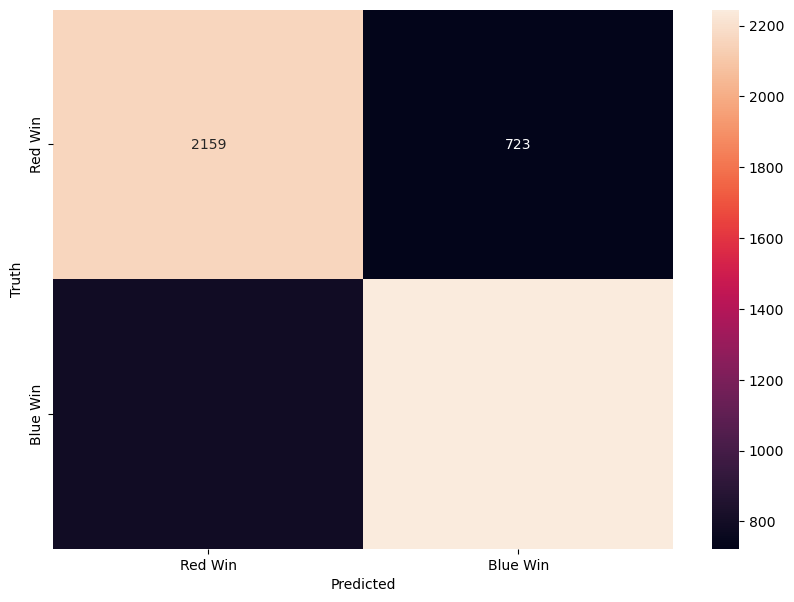

Gradient Boosting Classifier with Feature Selection Accuracy: 74.4%
Classification Report for Gradient Boosting Classifier with Feature Selection:
              precision    recall  f1-score      support
0              0.731369  0.749133  0.740144  2882.000000
1              0.756402  0.738973  0.747586  3038.000000
accuracy       0.743919  0.743919  0.743919     0.743919
macro avg      0.743885  0.744053  0.743865  5920.000000
weighted avg   0.744215  0.743919  0.743963  5920.000000


In [59]:
(training_inputs, testing_inputs, training_labels, testing_labels) = train_test_split(data_top_features, labels, test_size=0.25, random_state=42)

fs_gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=4, random_state=42)
fs_gradient_boosting_classifier.fit(training_inputs, training_labels)
predictions = fs_gradient_boosting_classifier.predict(testing_inputs)

cm = confusion_matrix(testing_labels, predictions)

plt.figure(figsize=(10, 7))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=['Red Win', 'Blue Win'], yticklabels=['Red Win', 'Blue Win'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

accuracy = round(accuracy_score(testing_labels, predictions), 3) * 100
print(f'Gradient Boosting Classifier with Feature Selection Accuracy: {accuracy}%')

cr = classification_report(testing_labels, predictions, output_dict=True)
df_report = pd.DataFrame(cr).transpose()
print("Classification Report for Gradient Boosting Classifier with Feature Selection:")
print(df_report)

In [60]:
top_gbc_scores = cross_val_score(fs_gradient_boosting_classifier, data_top_features.values, labels, cv=10)
print(f'Mean cross-validation score: {round(top_gbc_scores.mean(), 4) * 100}%')

Mean cross-validation score: 75.42999999999999%


Adding Feature Selection seems to also very slightly improve the performance of the `Gradient Boosting Classifier`.

Now, let's compare a simple Decision Tree Classifier with a Gradient Boosting Classifier with Feature Selection

Average difference of scores between Gradient Boosting and simple Decision Tree: 8.95%


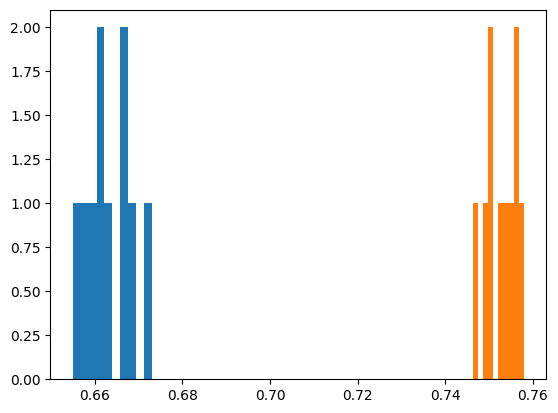

In [24]:
fs_gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=4, random_state=42)

mean_difference = compare_models(decision_tree_classifier, fs_gradient_boosting_classifier, inputs, data_top_features.values, labels)
print(f'Average difference of scores between Gradient Boosting and simple Decision Tree: {mean_difference}%')

As we can see, the Gradient Boosting Classifier with feature selection has, on average, almost 9% better accuracy than a simple Decision Tree Classifier, bumping up the 65-66% figure to around a 75%. 

### SVM Model

For the SVM Model, we will use the same features decided after the feature selection step.
SVM requires each feature to be on a similar scale, so we will use **StandardScaler** for that.

In [61]:
(svm_training_inputs, svm_testing_inputs, svm_training_labels, svm_testing_labels) = train_test_split(data_top_features, labels, test_size=0.25, random_state=42)

In [62]:
scaler = StandardScaler()
scaler.fit(svm_training_inputs)

scaled_training_inputs = scaler.transform(svm_training_inputs)
scaled_testing_inputs = scaler.transform(svm_testing_inputs)

Now, we need to determine the best values for the regularization parameter (`C`) and kernel coefficient (`gamma`). To do that, we will use `GridSearchCV`.

In [63]:
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['linear']}

grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=3)

grid.fit(scaled_training_inputs, svm_training_labels)

print(grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.761 total time=   3.4s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.760 total time=   3.2s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.763 total time=   3.3s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.769 total time=   3.3s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.754 total time=   3.2s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.761 total time=   3.3s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.760 total time=   3.1s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.763 total time=   3.1s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.769 total time=   3.2s
[CV 5/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.754 total time=   3.2s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.761 total time=   3.3s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear;

The `GridSearchCV` tells us that the best regularization parameter (`C`) is 1 and the best kernel coefficient (`gamma`) is 1.
Therefore, we will use these values in our `SVM` model.

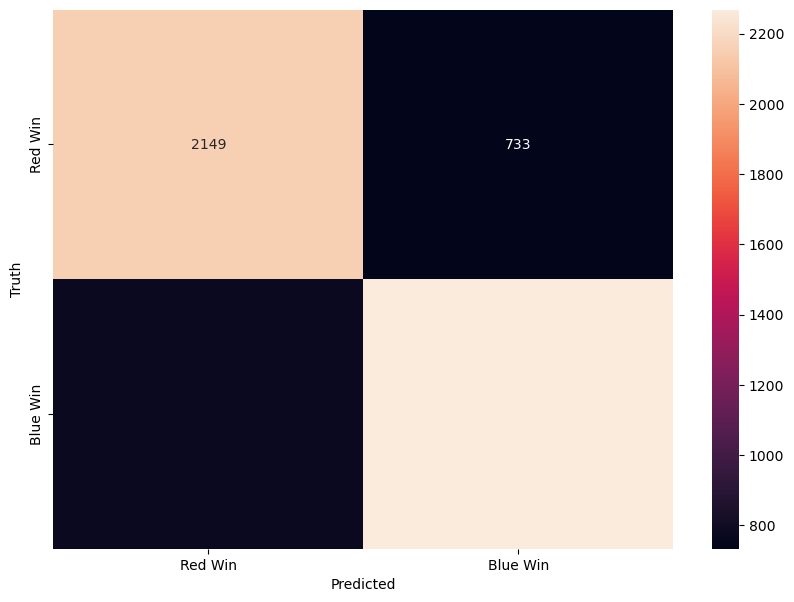

SVM Accuracy: 74.6%
Classification Report for SVM:
              precision    recall  f1-score      support
0              0.736211  0.745663  0.740907  2882.000000
1              0.755748  0.746544  0.751118  3038.000000
accuracy       0.746115  0.746115  0.746115     0.746115
macro avg      0.745980  0.746103  0.746012  5920.000000
weighted avg   0.746237  0.746115  0.746147  5920.000000


In [64]:
svm_model = svm.SVC(kernel="linear", gamma=1.0, C=1.0, verbose = False)
svm_model.fit(scaled_training_inputs, svm_training_labels)
predictions = svm_model.predict(scaled_testing_inputs)

cm = confusion_matrix(testing_labels, predictions)

plt.figure(figsize=(10, 7))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=['Red Win', 'Blue Win'], yticklabels=['Red Win', 'Blue Win'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

accuracy = round(accuracy_score(testing_labels, predictions), 3) * 100
print(f'SVM Accuracy: {accuracy}%')

cr = classification_report(testing_labels, predictions, output_dict=True)
df_report = pd.DataFrame(cr).transpose()
print("Classification Report for SVM:")
print(df_report)

Now closer to 75%, this `SVM` model appears to be slightly better than the `Gradient Boosting Classifier` with `Feature Selection`.

In [65]:
svm_scores = cross_val_score(svm_model, data_top_features.values, labels, cv=10)
print(f'Mean cross-validation score: {round(svm_scores.mean(), 4) * 100}%')

Mean cross-validation score: 75.44999999999999%


### K-Nearest Neighbours

#### Standard K-Nearest Neighbours execution

In [21]:
k_data = data.drop(columns=['blueWin'])
k_inputs = k_data.values
k_labels = data['blueWin'].values

Now we split our data into training and test sets

In [22]:
(k_training_inputs, k_testing_inputs, k_training_labels, k_testing_labels) = train_test_split(k_inputs, k_labels, test_size=0.25, random_state=42)

Since KNN is distance-based, we need to standardize our data

In [23]:
scaler = StandardScaler()
scaler.fit(k_training_inputs)

k_training_inputs = scaler.transform(k_training_inputs)
k_testing_inputs = scaler.transform(k_testing_inputs)

Now, let's train our KNN classifier. Let's try with a small k, for example 5.
For a small k we know that it will have a low bias and a high variance, which can be overfitting

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(k_training_inputs, k_training_labels)

Now let's make predictions on our test data and evaluate our model

In [25]:
testing_predictions = knn.predict(k_testing_inputs)

print(confusion_matrix(k_testing_labels, testing_predictions))
print(classification_report(k_testing_labels, testing_predictions))

[[2036  846]
 [ 889 2149]]
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      2882
           1       0.72      0.71      0.71      3038

    accuracy                           0.71      5920
   macro avg       0.71      0.71      0.71      5920
weighted avg       0.71      0.71      0.71      5920



With k = 5, we reached an average precision of 71%! Let's cross validate to ensure an accurate avaliation of the model

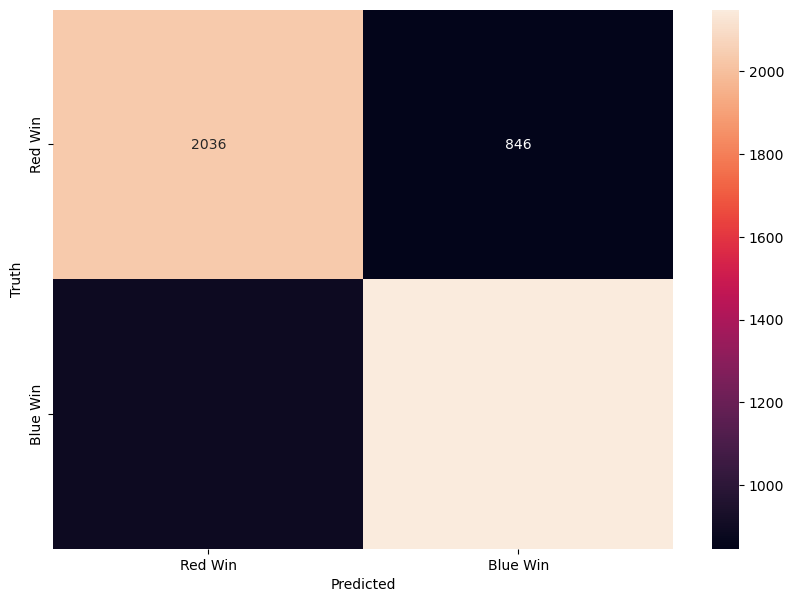

[[2036  846]
 [ 889 2149]]
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      2882
           1       0.72      0.71      0.71      3038

    accuracy                           0.71      5920
   macro avg       0.71      0.71      0.71      5920
weighted avg       0.71      0.71      0.71      5920

Cross-validation scores:  [0.72128378 0.72719595 0.72846284 0.72212838 0.70988176 0.71959459
 0.7035473  0.69383446 0.70553443 0.70130967]
Mean cross-validation score:  0.7132773160517933


In [26]:
cm = confusion_matrix(k_testing_labels, testing_predictions)

plt.figure(figsize=(10, 7))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=['Red Win', 'Blue Win'], yticklabels=['Red Win', 'Blue Win'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

print(confusion_matrix(k_testing_labels, testing_predictions))
print(classification_report(k_testing_labels, testing_predictions))

# Cross Validation
n5_scores = cross_val_score(knn, k_inputs, k_labels, cv=10)
print("Cross-validation scores: ", n5_scores)
print("Mean cross-validation score: ", n5_scores.mean())

##### Finding Best K

The optimal number of neighbors is 333


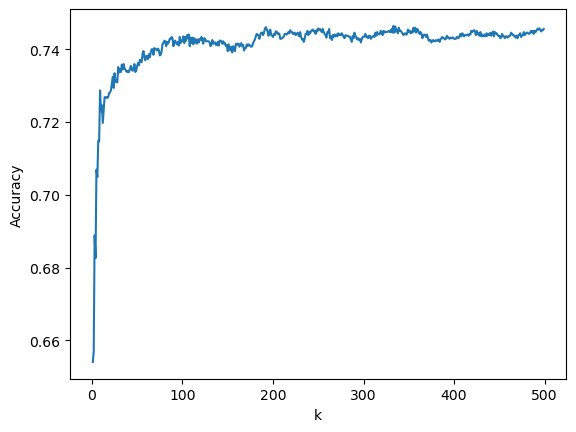

In [27]:
# List to hold the different accuracy scores
accuracy_scores = []

# Range of k values to try
k_values = range(1, 500)

# Loop over k values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(k_training_inputs, k_training_labels)
    y_pred = knn.predict(k_testing_inputs)
    accuracy = accuracy_score(k_testing_labels, y_pred)
    accuracy_scores.append(accuracy)

# Find the k value that gave the highest accuracy
optimal_k = k_values[accuracy_scores.index(max(accuracy_scores))]

print(f"The optimal number of neighbors is {optimal_k}")

plt.plot(k_values, accuracy_scores)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

By looking at this graph we notice that it reaches a point where it has very small variations along somewhat >50.
Let's see the values for the optimal number of k, which is 333 when looking between 1 and 500

##### Cross Validate

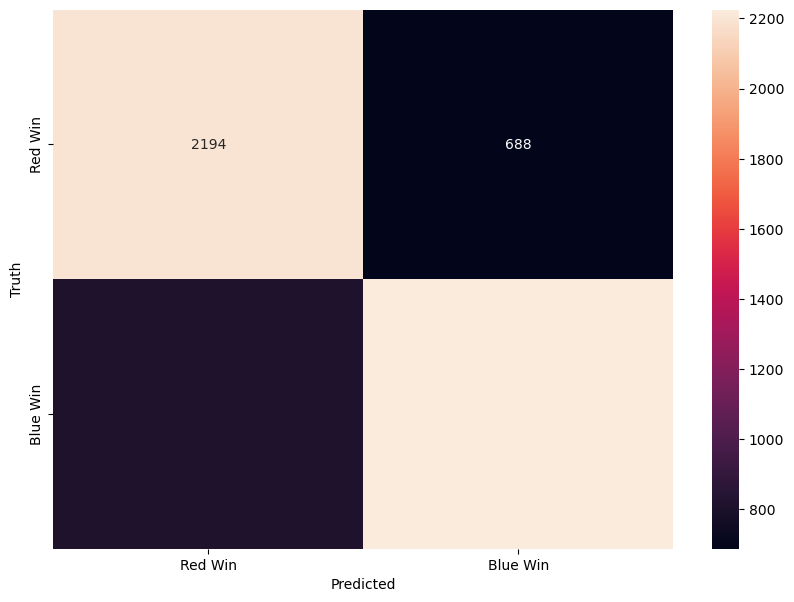

[[2194  688]
 [ 813 2225]]
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      2882
           1       0.76      0.73      0.75      3038

    accuracy                           0.75      5920
   macro avg       0.75      0.75      0.75      5920
weighted avg       0.75      0.75      0.75      5920

Cross-validation scores:  [0.76815878 0.75591216 0.76055743 0.74324324 0.74366554 0.74451014
 0.72635135 0.72508446 0.74313477 0.74059992]
Mean cross-validation score:  0.7451217793363706


In [28]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(k_training_inputs, k_training_labels)

testing_predictions = knn.predict(k_testing_inputs)

cm = confusion_matrix(k_testing_labels, testing_predictions)

plt.figure(figsize=(10, 7))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=['Red Win', 'Blue Win'], yticklabels=['Red Win', 'Blue Win'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

print(confusion_matrix(k_testing_labels, testing_predictions))
print(classification_report(k_testing_labels, testing_predictions))

# Cross Validation
bestk_scores = cross_val_score(knn, k_inputs, k_labels, cv=10)
print("Cross-validation scores: ", bestk_scores)
print("Mean cross-validation score: ", bestk_scores.mean())

So with this algorithm we reached an optimal 0.75 precision value!
But, when validating using the mean cross-validation score, we go back to the previously achieved 74.5%!

#### K-Nearest Neighbours using Top Features
Let's try now using the top features data to see if we can achieve an even better result

##### Permutation Importance
Let's find the importance of each feature for KNN!

In [30]:
X = data.drop('blueWin', axis=1)
y = data['blueWin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale our data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train a KNN classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Calculate permutation importance
results = permutation_importance(knn, X_test, y_test, scoring='accuracy')

# Get importance
importance = results.importances_mean

# Create a dictionary with feature names and importance scores
importance_dict = dict(zip(X.columns, importance))

# Sort the dictionary by values in descending order
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)

# Print the sorted feature importance
for feature, score in sorted_importance:
    print('Feature: %s, Score: %.5f' % (feature, score))


Feature: blueTeamTotalGold, Score: 0.01432
Feature: blueTeamXp, Score: 0.01412
Feature: blueTeamTotalKills, Score: 0.01162
Feature: redTeamXp, Score: 0.01108
Feature: redTeamTotalKills, Score: 0.01078
Feature: redTeamTotalGold, Score: 0.01071
Feature: redTeamDragonKills, Score: 0.00858
Feature: blueTeamDragonKills, Score: 0.00791
Feature: blueTeamTotalDamageToChamps, Score: 0.00716
Feature: blueTeamJungleMinions, Score: 0.00534
Feature: blueTeamTowersDestroyed, Score: 0.00517
Feature: redTeamHeraldKills, Score: 0.00355
Feature: blueTeamMinionsKilled, Score: 0.00260
Feature: blueTeamWardsPlaced, Score: 0.00213
Feature: redTeamMinionsKilled, Score: 0.00179
Feature: redTeamControlWardsPlaced, Score: 0.00176
Feature: blueTeamControlWardsPlaced, Score: 0.00145
Feature: redTeamTotalDamageToChamps, Score: 0.00095
Feature: redTeamWardsPlaced, Score: 0.00078
Feature: redTeamJungleMinions, Score: 0.00064
Feature: blueTeamHeraldKills, Score: 0.00047
Feature: blueTeamTurretPlatesDestroyed, Score: 

##### Remove features with negative importance
Features such as ``blueTeamFirstBlood``, ``redTeamTowersDestroyed`` and ``redTeamTurretPlatesDestroyed`` got negative values, so this tells us that the model would be probably better off without them, so let's try removing them!

In [29]:
knn_inputs_without_neg = data.drop('blueWin', axis=1)
knn_labels_without_neg = data['blueWin']

features_to_drop = ['blueTeamFirstBlood', 'redTeamTowersDestroyed', 'redTeamTurretPlatesDestroyed']

knn_inputs_without_neg = knn_inputs_without_neg.drop(features_to_drop, axis=1)

In [30]:
# Split the data again after dropping features
X_train, X_test, y_train, y_test = train_test_split(knn_inputs_without_neg, knn_labels_without_neg, test_size=0.25, random_state=42)

# Scale our data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Test the model
accuracy = knn.score(X_test, y_test)

print(confusion_matrix(y_test, knn.predict(X_test)))
print(classification_report(y_test, knn.predict(X_test)))

[[2066  816]
 [ 900 2138]]
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      2882
           1       0.72      0.70      0.71      3038

    accuracy                           0.71      5920
   macro avg       0.71      0.71      0.71      5920
weighted avg       0.71      0.71      0.71      5920



This value is the same as we got before, but let's try to find an optimal K and cross-validate!

##### Finding Best K

The optimal number of neighbors is 194


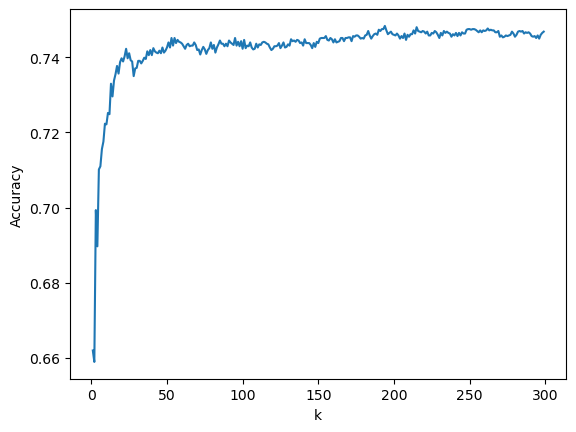

In [31]:
# List to hold the different accuracy scores
accuracy_scores = []

# Range of k values to try
k_values = range(1, 300)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(knn_inputs_without_neg, knn_labels_without_neg, test_size=0.25, random_state=42)

# Scale our data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Loop over k values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Find the k value that gave the highest accuracy
optimal_k = k_values[accuracy_scores.index(max(accuracy_scores))]

print(f"The optimal number of neighbors is {optimal_k}")

plt.plot(k_values, accuracy_scores)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

##### Cross Validate

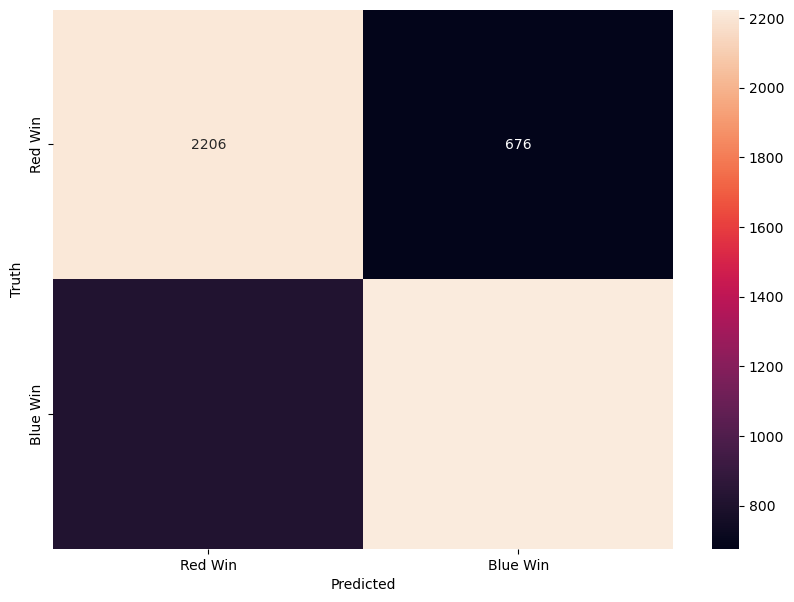

[[2206  676]
 [ 814 2224]]
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      2882
           1       0.77      0.73      0.75      3038

    accuracy                           0.75      5920
   macro avg       0.75      0.75      0.75      5920
weighted avg       0.75      0.75      0.75      5920

Cross-validation scores:  [0.77280405 0.75633446 0.76097973 0.74577703 0.74493243 0.74831081
 0.73564189 0.72846284 0.7460921  0.73933249]
Mean cross-validation score:  0.7478667831329429


In [32]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

testing_predictions = knn.predict(X_test)


cm = confusion_matrix(y_test, testing_predictions)

plt.figure(figsize=(10, 7))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=['Red Win', 'Blue Win'], yticklabels=['Red Win', 'Blue Win'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

print(confusion_matrix(y_test, testing_predictions))
print(classification_report(y_test, testing_predictions))

# Cross Validation
top_scores = cross_val_score(knn, knn_inputs_without_neg, knn_labels_without_neg, cv=10)
print("Cross-validation scores: ", top_scores)
print("Mean cross-validation score: ", top_scores.mean())

As we can see, we got a slight improvement of almost 0.003 and we even managed to get 77% precision on a specific test!

#### K-Nearest Neighbours with extra features
Now, let's try to add some new features, such as the difference between everything!

##### Adding new features

In [33]:
knn_extra_df = data.copy()

# List of features to calculate the difference
features = ['ControlWardsPlaced', 'WardsPlaced', 'TotalKills', 'DragonKills', 'HeraldKills', 
            'TowersDestroyed', 'InhibitorsDestroyed', 'TurretPlatesDestroyed', 
            'MinionsKilled', 'JungleMinions', 'TotalGold', 'Xp', 'TotalDamageToChamps']

# Add new columns with the difference between blue and red features
for feature in features:
    knn_extra_df[f'diff_{feature}'] = knn_extra_df[f'blueTeam{feature}'] - knn_extra_df[f'redTeam{feature}']

knn_extra_df.head(5)

,blueTeamControlWardsPlaced,blueTeamWardsPlaced,blueTeamTotalKills,blueTeamDragonKills,blueTeamHeraldKills,blueTeamTowersDestroyed,blueTeamInhibitorsDestroyed,redTeamTurretPlatesDestroyed,blueTeamFirstBlood,blueTeamMinionsKilled,...,diff_DragonKills,diff_HeraldKills,diff_TowersDestroyed,diff_InhibitorsDestroyed,diff_TurretPlatesDestroyed,diff_MinionsKilled,diff_JungleMinions,diff_TotalGold,diff_Xp,diff_TotalDamageToChamps
0,2,23,4,2,0,0,0,7,0,388,...,2,0,-2,0,-6,-12,12,-5714,-2815,-5397
1,2,46,12,1,0,1,0,10,0,348,...,1,0,0,0,-6,-25,22,-1118,210,-768
2,2,19,13,0,0,0,0,11,0,331,...,-1,0,-2,0,-8,-9,12,-2384,37,-4945
3,3,28,8,0,1,1,0,9,1,355,...,-1,1,1,0,-4,-23,-3,2176,-603,3109
4,3,30,11,1,1,1,0,7,0,370,...,0,1,0,0,-2,-12,4,1720,1591,7431


##### Create our new model

In [34]:
knn_extra_inputs = knn_extra_df.drop('blueWin', axis=1)
knn_extra_labels = knn_extra_df['blueWin']

X_train, X_test, y_train, y_test = train_test_split(knn_extra_inputs, knn_extra_labels, test_size=0.25, random_state=42)

# Scale our data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train our new KNN classifier with 5 neighbors
knn_extra = KNeighborsClassifier(n_neighbors=5)
knn_extra.fit(X_train, y_train)

# Test the model
accuracy = knn_extra.score(X_test, y_test)

print(confusion_matrix(y_test, knn_extra.predict(X_test)))
print(classification_report(y_test, knn_extra.predict(X_test)))

[[2034  848]
 [ 863 2175]]
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      2882
           1       0.72      0.72      0.72      3038

    accuracy                           0.71      5920
   macro avg       0.71      0.71      0.71      5920
weighted avg       0.71      0.71      0.71      5920



Seems equal to the one we first created. Let's continue by finding an optimal k and cross-validating

##### Finding Best K

The optimal number of neighbors is 268


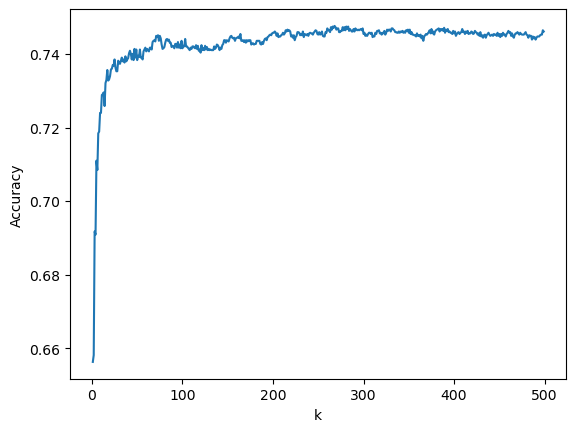

In [36]:
# List to hold the different accuracy scores
accuracy_scores = []

# Range of k values to try
k_values = range(1, 500)

# Loop over k values
for k in k_values:
    knn_extra = KNeighborsClassifier(n_neighbors=k)
    knn_extra.fit(X_train, y_train)
    y_pred = knn_extra.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Find the k value that gave the highest accuracy
optimal_k = k_values[accuracy_scores.index(max(accuracy_scores))]

print(f"The optimal number of neighbors is {optimal_k}")

plt.plot(k_values, accuracy_scores)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

##### Cross Validate

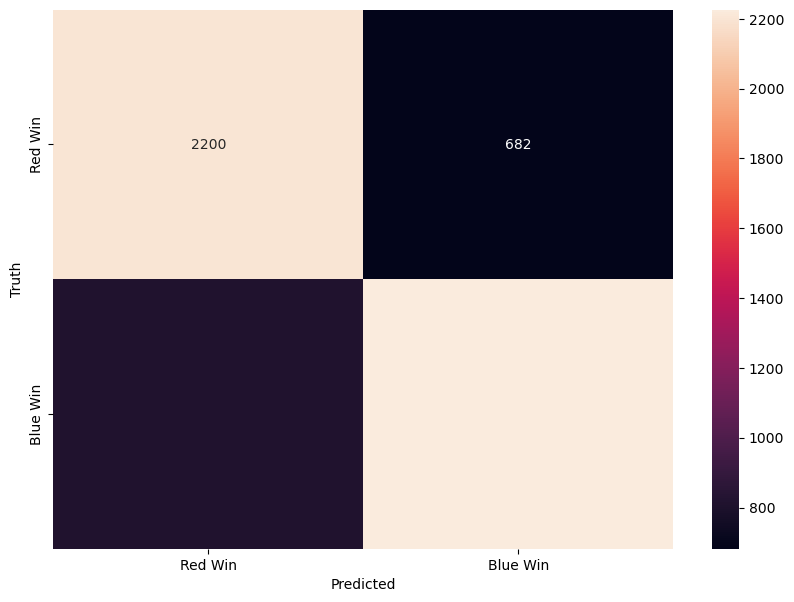

[[2200  682]
 [ 812 2226]]
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      2882
           1       0.77      0.73      0.75      3038

    accuracy                           0.75      5920
   macro avg       0.75      0.75      0.75      5920
weighted avg       0.75      0.75      0.75      5920

Cross-validation scores:  [0.76478041 0.75717905 0.76731419 0.74662162 0.74662162 0.74915541
 0.73775338 0.72804054 0.74482467 0.73975496]
Mean cross-validation score:  0.7482045852887108


In [38]:
knn_extra = KNeighborsClassifier(n_neighbors=optimal_k)
knn_extra.fit(X_train, y_train)

testing_predictions = knn_extra.predict(X_test)


cm = confusion_matrix(y_test, testing_predictions)

plt.figure(figsize=(10, 7))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=['Red Win', 'Blue Win'], yticklabels=['Red Win', 'Blue Win'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

print(confusion_matrix(y_test, testing_predictions))
print(classification_report(y_test, testing_predictions))

# Cross Validation
new_scores = cross_val_score(knn_extra, knn_extra_inputs, knn_extra_labels, cv=10)
print("Cross-validation scores: ", new_scores)
print("Mean cross-validation score: ", new_scores.mean())

As we can see, we managed to improve again by a slight 0.001. Maybe with the top features of this DataFrame we manage to up it even further

#### K-Nearest Neighbours with extra Top Features

##### Permutation Importance

In [48]:
X = knn_extra_df.drop('blueWin', axis=1)
y = knn_extra_df['blueWin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale our data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train our KNN classifier
knn_extra_tf = KNeighborsClassifier()
knn_extra_tf.fit(X_train, y_train)

# Calculate permutation importance
results = permutation_importance(knn_extra_tf, X_test, y_test, scoring='accuracy')

# Get importance
importance = results.importances_mean

# Create a dictionary with feature names and importance scores
importance_dict = dict(zip(X.columns, importance))

# Sort the dictionary by values in descending order
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)

# Print the sorted feature importance
for feature, score in sorted_importance:
    print('Feature: %s, Score: %.5f' % (feature, score))

Feature: blueTeamTotalGold, Score: 0.01233
Feature: diff_Xp, Score: 0.01209
Feature: diff_TotalGold, Score: 0.00997
Feature: diff_TotalKills, Score: 0.00946
Feature: redTeamTotalKills, Score: 0.00865
Feature: redTeamXp, Score: 0.00858
Feature: diff_DragonKills, Score: 0.00764
Feature: blueTeamDragonKills, Score: 0.00747
Feature: blueTeamTotalKills, Score: 0.00726
Feature: redTeamTotalGold, Score: 0.00716
Feature: blueTeamTowersDestroyed, Score: 0.00699
Feature: blueTeamXp, Score: 0.00662
Feature: diff_TotalDamageToChamps, Score: 0.00554
Feature: blueTeamControlWardsPlaced, Score: 0.00520
Feature: diff_JungleMinions, Score: 0.00503
Feature: redTeamDragonKills, Score: 0.00480
Feature: diff_ControlWardsPlaced, Score: 0.00470
Feature: blueTeamTurretPlatesDestroyed, Score: 0.00466
Feature: diff_TurretPlatesDestroyed, Score: 0.00426
Feature: redTeamTotalDamageToChamps, Score: 0.00395
Feature: redTeamTurretPlatesDestroyed, Score: 0.00338
Feature: diff_TowersDestroyed, Score: 0.00230
Feature: 

##### Dropping features with negative importance and training our model
Let's try removing the only ones that received a negative score: ``blueTeamFirstBlood``, ``redTeamMinionsKilled``, ``diff_WardsPlaced``, ``diff_HeraldKills``, and ``redTeamWardsPlaced``


In [39]:
features_to_drop = ['blueTeamFirstBlood', 'redTeamMinionsKilled', 'diff_WardsPlaced',
                    'diff_HeraldKills', 'redTeamWardsPlaced']

knn_extra_df_tf = knn_extra_df.drop(features_to_drop, axis=1)

knn_extra_tf_inputs = knn_extra_df_tf.drop('blueWin', axis=1)
knn_extra_tf_labels = knn_extra_df_tf['blueWin']

In [40]:
# Split the data again after dropping features
X_train, X_test, y_train, y_test = train_test_split(knn_extra_tf_inputs, knn_extra_tf_labels, test_size=0.25, random_state=42)

# Scale our data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

knn_extra_tf = KNeighborsClassifier(n_neighbors=5)
knn_extra_tf.fit(X_train, y_train)

# Test the model
accuracy = knn_extra_tf.score(X_test, y_test)

print(confusion_matrix(y_test, knn_extra_tf.predict(X_test)))
print(classification_report(y_test, knn_extra_tf.predict(X_test)))

[[2073  809]
 [ 870 2168]]
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      2882
           1       0.73      0.71      0.72      3038

    accuracy                           0.72      5920
   macro avg       0.72      0.72      0.72      5920
weighted avg       0.72      0.72      0.72      5920



Seems slightly better than the rest, but let's try to find the best k!
##### Finding best K

The optimal number of neighbors is 233


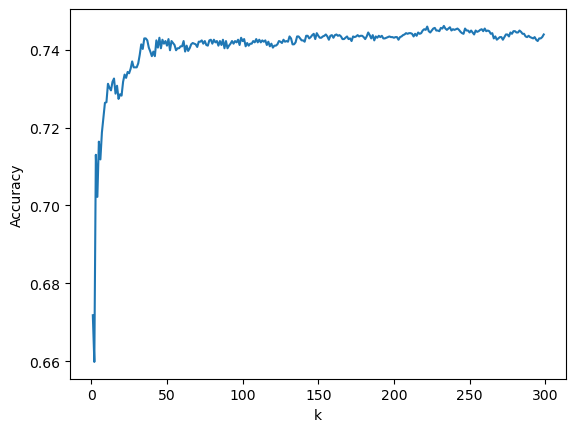

In [41]:
# List to hold the different accuracy scores
accuracy_scores = []

# Range of k values to try
k_values = range(1, 300)

# Loop over k values
for k in k_values:
    knn_extra_tf = KNeighborsClassifier(n_neighbors=k)
    knn_extra_tf.fit(X_train, y_train)
    y_pred = knn_extra_tf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Find the k value that gave the highest accuracy
optimal_k = k_values[accuracy_scores.index(max(accuracy_scores))]

print(f"The optimal number of neighbors is {optimal_k}")

plt.plot(k_values, accuracy_scores)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

##### Cross Validate

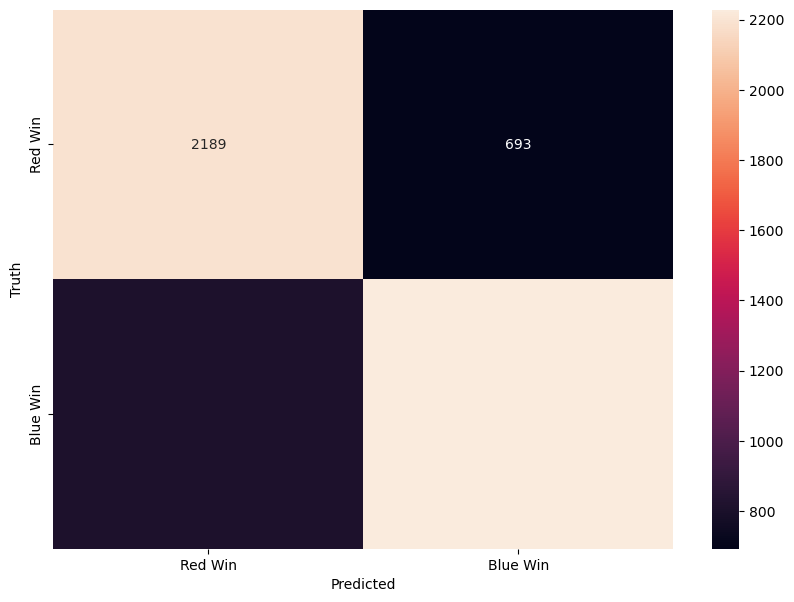

[[2189  693]
 [ 810 2228]]
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      2882
           1       0.76      0.73      0.75      3038

    accuracy                           0.75      5920
   macro avg       0.75      0.75      0.75      5920
weighted avg       0.75      0.75      0.75      5920

Cross-validation scores:  [0.76646959 0.75971284 0.76773649 0.75       0.74746622 0.7504223
 0.73564189 0.72761824 0.74566962 0.73722011]
Mean cross-validation score:  0.7487957301407872


In [42]:
knn_extra_tf = KNeighborsClassifier(n_neighbors=optimal_k)
knn_extra_tf.fit(X_train, y_train)

testing_predictions = knn_extra_tf.predict(X_test)


cm = confusion_matrix(y_test, testing_predictions)

plt.figure(figsize=(10, 7))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=['Red Win', 'Blue Win'], yticklabels=['Red Win', 'Blue Win'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

print(cm)
print(classification_report(y_test, testing_predictions))

# Cross Validation
top_new_scores = cross_val_score(knn_extra_tf, knn_extra_tf_inputs, knn_extra_tf_labels, cv=10)
print("Cross-validation scores: ", top_new_scores)
print("Mean cross-validation score: ", top_new_scores.mean())

As we can see, we managed to increase our model by a minimal 0.0006!

#### Let's compare all our KNN Models

In [49]:
def plot_cross_val_scores(model_names, cv_scores):
    # Create a new figure with a specified size (width, height)
    plt.figure(figsize=(10, 6))

    # Create boxplot
    plt.boxplot(cv_scores, labels=model_names, patch_artist=True, medianprops={'linewidth': 2})
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    plt.xlabel('Model')
    plt.ylabel('Cross-Validation Score')
    plt.title('Comparison of K-Nearest Neighbours Models Cross-Validation Scores')
    plt.tight_layout()
    plt.show()

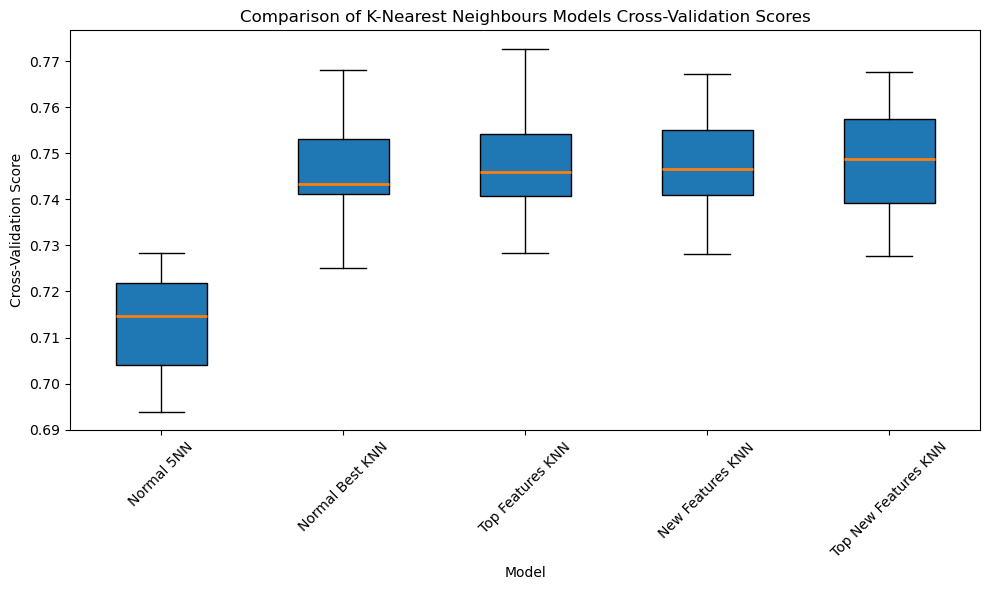

In [50]:
model_names = ["Normal 5NN", "Normal Best KNN", "Top Features KNN", "New Features KNN", "Top New Features KNN"]
cv_scores = [n5_scores, bestk_scores, top_scores, new_scores, top_new_scores]

plot_cross_val_scores(model_names, cv_scores)

As we can see, choosing the best K is an important part of the KNN model. Also, we see that if we eliminate some non-important features and add new ones that are relevant to the model we manage to improve the mean score.

### Neural Network

In [66]:
tensor_data = data.drop(columns=['blueWin'])
tensor_inputs = tensor_data.values
tensor_labels = data['blueWin'].values

(tensor_training_inputs, tensor_testing_inputs, tensor_training_labels, tensor_testing_labels) = train_test_split(tensor_inputs, tensor_labels, test_size=0.25, random_state=42)

Tensor flow doesn't require any other data modification

Base Case:

Epoch 1/200
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6497 - loss: 272.7873
Epoch 2/200
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6750 - loss: 50.6073
Epoch 3/200
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6654 - loss: 31.5575
Epoch 4/200
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6730 - loss: 14.7745
Epoch 5/200
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6731 - loss: 13.4527
Epoch 6/200
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6853 - loss: 7.5932
Epoch 7/200
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6676 - loss: 5.9597
Epoch 8/200
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6712 - loss: 3.7017
Epoch 9/200
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6652 - loss: 3.0165
Epoch 10/200
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6839 - loss: 1.3551
Epoch 11/200
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6821 - loss: 1.0564
Epoch 12/200
555/555 ━━━━━━━━━━━━━━

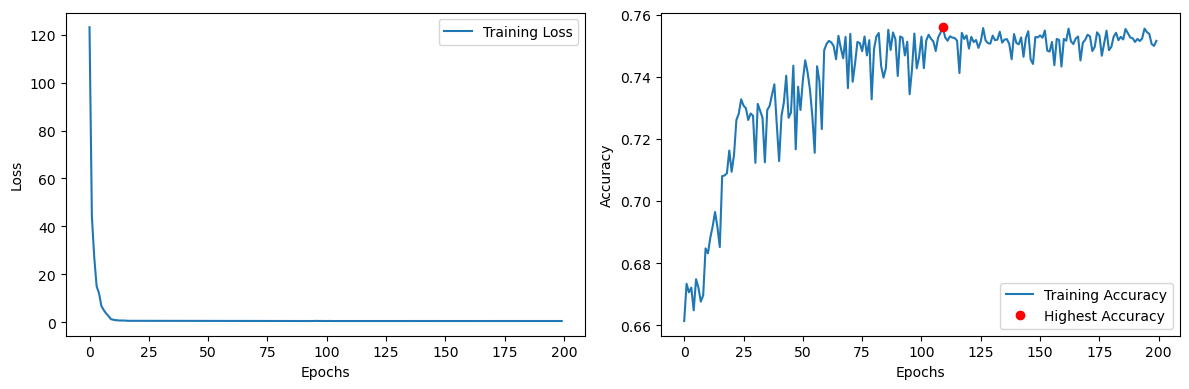

Test Loss: 0.5338383316993713
Maximum Accuracyon training: 0.7559409737586975
Test Accuracy: 0.7385135293006897


In [67]:
neural_model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

neural_model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = neural_model_1.fit(tensor_training_inputs, tensor_training_labels, epochs=200)

# Evaluate the model
test_loss, test_accuracy = neural_model_1.evaluate(tensor_testing_inputs, tensor_testing_labels)

# Plot the training loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')

# Find the epoch with the highest accuracy
max_acc_epoch = np.argmax(history.history['accuracy'])

# Plot a red dot at the highest point
plt.plot(max_acc_epoch, history.history['accuracy'][max_acc_epoch], 'ro', label='Highest Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Test Loss: {test_loss}")
print(f"Maximum Accuracyon training: {history.history['accuracy'][max_acc_epoch]}")
print(f"Test Accuracy: {test_accuracy}")


We can also try to remove noise to see if it leads to beter results

In [ ]:
features_to_drop = ['blueTeamFirstBlood', 'redTeamTowersDestroyed', 'redTeamTurretPlatesDestroyed']
dropped_data = data.drop(features_to_drop, axis=1)
tensor_data_2 = dropped_data.drop(columns=['blueWin'])
tensor_inputs_2 = tensor_data_2.values
tensor_labels_2 = dropped_data['blueWin'].values

(tensor_training_inputs_2, tensor_testing_inputs_2, tensor_training_labels_2, tensor_testing_labels_2) = train_test_split(tensor_inputs_2, tensor_labels_2, test_size=0.25, random_state=42)

In [ ]:
neural_model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

neural_model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = neural_model_2.fit(tensor_training_inputs_2, tensor_training_labels_2, epochs=200)

# Evaluate the model
test_loss_2, test_accuracy_2 = neural_model_2.evaluate(tensor_testing_inputs_2, tensor_testing_labels_2)

# Plot the training loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')

# Find the epoch with the highest accuracy
max_acc_epoch_2 = np.argmax(history.history['accuracy'])

# Plot a red dot at the highest point
plt.plot(max_acc_epoch_2, history.history['accuracy'][max_acc_epoch_2], 'ro', label='Highest Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Test Loss: {test_loss_2}")
print(f"Maximum Accuracy on training: {history.history['accuracy'][max_acc_epoch_2]}")
print(f"Test Accuracy: {test_accuracy_2}")

Now that we have trained two models, lets compare them

In [ ]:
# Evaluate the models on the test set
test_loss1, test_accuracy1 = neural_model_1.evaluate(tensor_testing_inputs, tensor_testing_labels)
test_loss2, test_accuracy2 = neural_model_2.evaluate(tensor_testing_inputs_2, tensor_testing_labels_2)

print(f"Test Accuracy for Model 1: {test_accuracy1}")
print(f"Test Accuracy for Model 2: {test_accuracy2}")

## Finally, let's compare all our results from SciKit

In [81]:
def plot_all_cross_val_scores(model_names, cv_scores):
    # Create a new figure with a specified size (width, height)
    plt.figure(figsize=(10, 6))

    # Create boxplot
    plt.boxplot(cv_scores, labels=model_names, patch_artist=True, medianprops={'linewidth': 2})
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    plt.xlabel('Model')
    plt.ylabel('Cross-Validation Score')
    plt.title('Comparison of Models Cross-Validation Scores')
    plt.tight_layout()
    plt.show()

    # Create a new figure for the histogram
    plt.figure(figsize=(10, 6))

    # Create histogram for each model's cross-validation scores
    for i, scores in enumerate(cv_scores):
        plt.hist(scores, alpha=0.5, label=model_names[i])

    plt.xlabel('Cross-Validation Score')
    plt.ylabel('Frequency')
    plt.title('Histogram of Models Cross-Validation Scores')
    plt.legend()
    plt.tight_layout()
    plt.show()

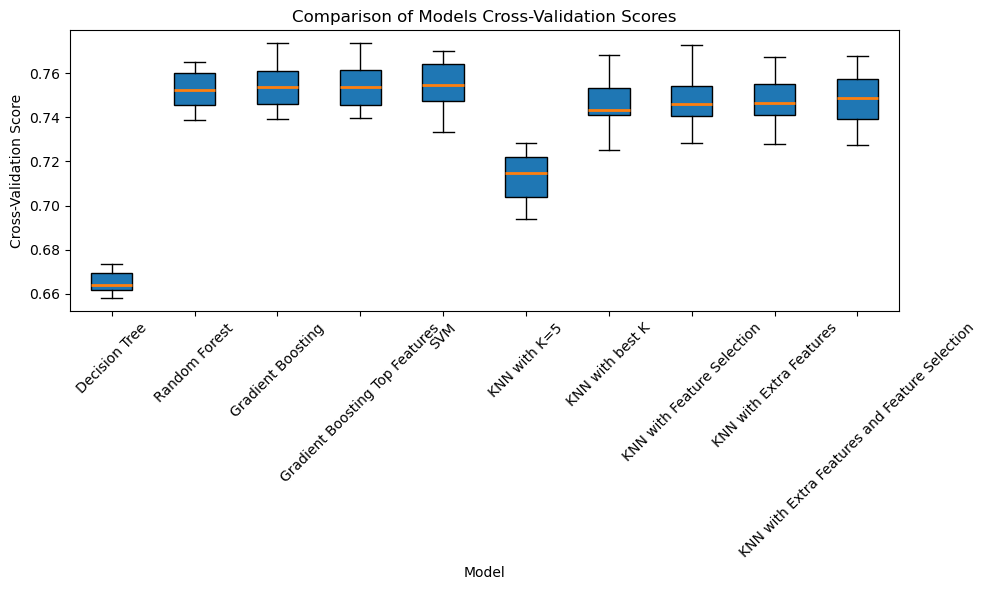

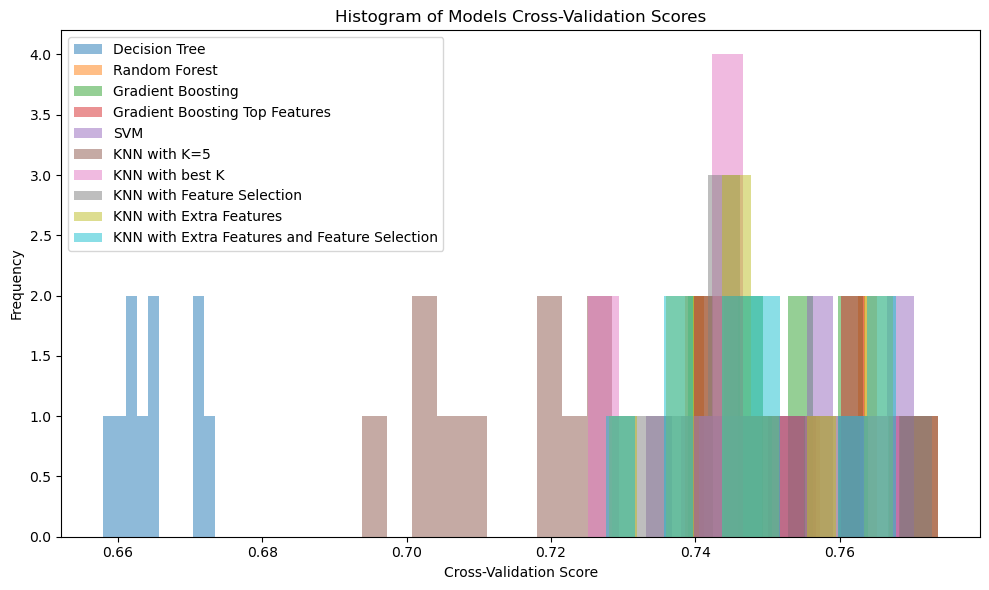

In [82]:
models_names = ["Decision Tree", "Random Forest", "Gradient Boosting", "Gradient Boosting Top Features" ,"SVM", "KNN with K=5","KNN with best K", "KNN with Feature Selection", "KNN with Extra Features", "KNN with Extra Features and Feature Selection"]
cv_scores = [dt_scores, rfc_scores, gbc_scores, top_gbc_scores, svm_scores, n5_scores, bestk_scores, top_scores, new_scores, top_new_scores]

plot_all_cross_val_scores(models_names, cv_scores)

## Using the trained model to predict game

Now that we have trained a model with over 24 thousand games, let's give it some real-world games and have it predict the game's outcome.

For that, we will use the `Riot Games` API to obtain information about a game.
We will use some of the matches we played.
Keep in mind the dataset collected and used to train the bot was of ranked matches between mid `emerald` to high `diamond`.
Not only is our skill level not that high, our games are also unranked. We expect this to affect the model's accuracy, since unranked games are usually not taken very seriously by players. Still, we think this is an interesting experiment.

In [29]:
api_key = 'YOUR API KEY' # Expires after 24 hours, get your own at https://developer.riotgames.com
region = 'europe'
game_name = 'Tonevanda' # Riot ID 
tag_line = '1906' # Riot tag
model = svm_model 

In [30]:
def get_player_matches(region, game_name, tag_line, api_key):
    url = f"https://{region}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{game_name}/{tag_line}?api_key={api_key}" # Just assuming EUW1 because whatever
    response = requests.get(url)
    if response.status_code != 200:
        print("Error: ", str(response.status_code))
        return None
    summoner_id = response.json()['puuid']
    url = f"https://{region}.api.riotgames.com/lol/match/v5/matches/by-puuid/{summoner_id}/ids?start=0&count=20&api_key={api_key}"
    response = requests.get(url)
    return response.json()

In [31]:
def get_match_data(region, match_id, api_key):

  api_url_timeline = "https://" + region + ".api.riotgames.com/lol/match/v5/matches/" + match_id + "/timeline?api_key=" + api_key

  while True:
    resp_timeline = requests.get(api_url_timeline)
    if resp_timeline.status_code == 429:
      time.sleep(10)
      print('Sleeping')
      continue
    elif resp_timeline.status_code == 200:
      break
    elif resp_timeline.status_code == 404:
      return 0
    else:
      print('Bad response: ' + str(resp_timeline.status_code))

  timeline_data = resp_timeline.json()
  return timeline_data

In [32]:
def get_match_state(data):

  blue_team = data['info']['participants'][:5]
  red_team = data['info']['participants'][5:]

  blueTeamMinionsKilled = 0
  redTeamMinionsKilled = 0
  blueTeamJungleMinions = 0
  redTeamJungleMinions = 0
  blueTeamTotalGold = 0
  redTeamTotalGold = 0
  blueTeamXp = 0
  redTeamXp = 0
  blueTeamTotalDamageToChamps = 0
  redTeamTotalDamageToChamps = 0
  blueTeamWardsPlaced = 0
  redTeamWardsPlaced = 0
  blueTeamTotalKills = 0
  redTeamTotalKills = 0
  blueTeamControlWardsPlaced = 0
  redTeamControlWardsPlaced = 0
  blueTeamDragonKills = 0
  redTeamDragonKills = 0
  blueTeamHeraldKills = 0
  redTeamHeraldKills = 0
  blueTeamTowersDestroyed = 0
  redTeamTowersDestroyed = 0
  blueTeamInhibitorsDestroyed = 0
  redTeamInhibitorsDestroyed = 0
  blueTeamTurretPlatesDestroyed = 0
  redTeamTurretPlatesDestroyed = 0
  blueTeamFirstBlood = 0
  blueWin = 0

  if len(data['info']['frames']) < 16:
    return 0

  for player in blue_team:
    blueTeamMinionsKilled += data['info']['frames'][15]['participantFrames'][str(player['participantId'])]['minionsKilled']
    blueTeamTotalGold += data['info']['frames'][15]['participantFrames'][str(player['participantId'])]['totalGold']
    blueTeamXp += data['info']['frames'][15]['participantFrames'][str(player['participantId'])]['xp']
    blueTeamJungleMinions += data['info']['frames'][15]['participantFrames'][str(player['participantId'])]['jungleMinionsKilled']
    blueTeamTotalDamageToChamps += data['info']['frames'][15]['participantFrames'][str(player['participantId'])]['damageStats']['totalDamageDoneToChampions']

  for player in red_team:
    redTeamMinionsKilled += data['info']['frames'][15]['participantFrames'][str(player['participantId'])]['minionsKilled']
    redTeamTotalGold += data['info']['frames'][15]['participantFrames'][str(player['participantId'])]['totalGold']
    redTeamXp += data['info']['frames'][15]['participantFrames'][str(player['participantId'])]['xp']
    redTeamJungleMinions += data['info']['frames'][15]['participantFrames'][str(player['participantId'])]['jungleMinionsKilled']
    redTeamTotalDamageToChamps += data['info']['frames'][15]['participantFrames'][str(player['participantId'])]['damageStats']['totalDamageDoneToChampions']

  for event in data['info']['frames'][-1]['events']:
    if event['type'] == 'GAME_END':
      if event['winningTeam'] == 100:
        blueWin = 1

  for i in range(16):
    for event in data['info']['frames'][i]['events']:
      if event['type'] == 'WARD_PLACED':
        if event['creatorId'] in range(1,6):
          if event['wardType'] == 'CONTROL_WARD':
              blueTeamControlWardsPlaced += 1
          blueTeamWardsPlaced += 1
        else:
          if event['wardType'] == 'CONTROL_WARD':
            redTeamControlWardsPlaced += 1
          redTeamWardsPlaced += 1

      if event['type'] == 'CHAMPION_KILL':
        if event['killerId'] in range(1,6):
          blueTeamTotalKills += 1
        else:
          redTeamTotalKills += 1

      if event['type'] == 'ELITE_MONSTER_KILL':
        if event['monsterType'] == 'DRAGON':
          if event['killerId'] in range(1,6):
            blueTeamDragonKills += 1
          else:
            redTeamDragonKills += 1
        if event['monsterType'] == 'RIFTHERALD':
          if event['killerId'] in range(1,6):
            blueTeamHeraldKills += 1
          else:
            redTeamHeraldKills += 1

      if event['type'] == 'BUILDING_KILL' and event['buildingType'] == 'TOWER_BUILDING':
        if event['killerId'] in range(1,6):
          blueTeamTowersDestroyed += 1
        else:
          redTeamTowersDestroyed  += 1

      if event['type'] == 'BUILDING_KILL' and event['buildingType'] == 'INHIBITOR_BUILDING':
        if event['killerId'] in range(1,6):
          blueTeamInhibitorsDestroyed += 1
        else:
          redTeamInhibitorsDestroyed  += 1

      if event['type'] == 'TURRET_PLATE_DESTROYED':
        if event['killerId'] in range(1,6):
          blueTeamTurretPlatesDestroyed += 1
        else:
          redTeamTurretPlatesDestroyed  += 1

      if event['type'] == 'CHAMPION_SPECIAL_KILL' and event['killType'] == 'KILL_FIRST_BLOOD':
        if event['killerId'] in range(1,6):
          blueTeamFirstBlood = 1

  row = [[data['metadata']['matchId'], blueTeamControlWardsPlaced, blueTeamWardsPlaced, blueTeamTotalKills,blueTeamDragonKills,blueTeamHeraldKills,blueTeamTowersDestroyed,blueTeamInhibitorsDestroyed,
                       blueTeamTurretPlatesDestroyed,blueTeamFirstBlood,blueTeamMinionsKilled,blueTeamJungleMinions,blueTeamTotalGold,blueTeamXp,blueTeamTotalDamageToChamps, redTeamControlWardsPlaced,
                       redTeamWardsPlaced,redTeamTotalKills,redTeamDragonKills,redTeamHeraldKills,redTeamTowersDestroyed,redTeamInhibitorsDestroyed,redTeamTurretPlatesDestroyed,redTeamMinionsKilled,
                       redTeamJungleMinions,redTeamTotalGold,redTeamXp,redTeamTotalDamageToChamps,blueWin]]

  return row

In [39]:
def predict_player_games(game_name, tag_line, model, top_features, region, api_key):
    match_ids = get_player_matches(region, game_name, tag_line, api_key)
    for match_id in match_ids:
        timeline_data = get_match_data(region, match_id, api_key)
        if timeline_data == 0:
            continue
        else:
            match_state = get_match_state(timeline_data)
            if match_state == 0:
                continue
            else:
                # Remove the matchID and blueWin columns
                row = [match_state[0][1:-1]]
                row = pd.DataFrame(row, columns=new_data.columns)

                # Remove wrong turret plates values
                remove_extra_plates_red = row[(row['redTeamTurretPlatesDestroyed'] > 15)]
                row.drop(remove_extra_plates_red.index, inplace=True)
                remove_extra_plates_blue = row[(row['blueTeamTurretPlatesDestroyed'] > 15)]
                row.drop(remove_extra_plates_blue.index, inplace=True)

                # Get the top features
                game_features = row[top_features].to_numpy()

                # Predict the outcome
                prediction = model.predict(game_features)
                if prediction == [1]:
                    print("Predicted outcome: Blue team wins")
                else:
                    print("Predicted outcome: Red team wins")

In [40]:
predict_player_games(game_name, tag_line, model, top_features, region, api_key)

Predicted outcome: Red team wins
Predicted outcome: Blue team wins
Predicted outcome: Blue team wins
Predicted outcome: Blue team wins
Predicted outcome: Blue team wins
Predicted outcome: Blue team wins
Predicted outcome: Blue team wins
Predicted outcome: Blue team wins
Predicted outcome: Blue team wins
Predicted outcome: Blue team wins
Predicted outcome: Blue team wins
Predicted outcome: Red team wins
Predicted outcome: Red team wins
Predicted outcome: Red team wins
Predicted outcome: Red team wins
Predicted outcome: Red team wins
Predicted outcome: Blue team wins
Predicted outcome: Blue team wins
Predicted outcome: Blue team wins
